# Solar Power Project

## Project Setup: Virtual Environment and Libraries 


For any serious project, using a **virtual environment** is essential. Think of it like having a **separate, dedicated workshop for each project**.

- **Without an environment:** It's like having one giant, messy toolbox for all your projects. If you upgrade a library for one project, it might break another project that relied on the old version.
- **With an environment:** Each project gets its own clean workshop and its own specific set of tools. They will never interfere with each other.

### Key Benefits:
- **Dependency Isolation:** Prevents conflicts between projects that require different versions of the same library.
- **Reproducibility:** Allows you to create a `requirements.txt` file that lists the exact versions of all libraries used, enabling anyone to perfectly recreate your setup.
- **Cleanliness:** Keeps your main computer's Python installation organized.

---

## Setup Instructions 

Here are the steps to set up the environment and install all the necessary libraries.

### 1. Create the Virtual Environment
Open your terminal or command prompt in your project folder and run:
```bash
python -m venv solar_env

```


### 2. Activate the Environment
You must activate the environment before installing libraries.


### 3. Install All Necessary Libraries
With the environment activated, run this single command:
```bash
pip install pandas numpy scikit-learn matplotlib seaborn lightgbm xgboost joblib
```

### 4. Create a requirements.txt File (For Reproducibility)
After everything is installed, lock in the versions for easy reproduction by running:

```bash
pip freeze > requirements.txt
```

This file can be shared so anyone can install the exact same libraries using pip install -r requirements.txt.

In [1]:
import sys, platform
print("Python path:", sys.executable)
print("Python version:", platform.python_version())


Python path: c:\Users\njood\anaconda3\envs\solar_env\python.exe
Python version: 3.12.12


In [2]:
%pip install torch pandas matplotlib numpy seaborn scikit-learn pyarrow fastparquet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
print(" CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(" GPU:", torch.cuda.get_device_name(0))


 CUDA Available: True
 GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## Libraries

In [3]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from IPython.display import display

#  Understanding Data Storage Formats

In data science and machine learning, how you **store and manage your data** can greatly affect performance, speed, and compatibility.  
Different file formats are designed for different purposes — some for **human readability**, others for **efficiency and compression**.

---

## 1. Text-Based Formats (Human-Readable)

These formats store data as plain text, making them easy to inspect, share, and edit manually.

| Format | Extension | Description | Advantages | Limitations |
|---------|------------|--------------|-------------|--------------|
| **CSV** | `.csv` | Comma-Separated Values — each line is a row, and commas separate columns. | Simple, universal, works with Excel and Python. | No data types, large files can be slow to load. |
| **TSV** | `.tsv` | Tab-Separated Values — similar to CSV but uses tabs. | Avoids confusion if text contains commas. | Still large and lacks metadata. |
| **JSON** | `.json` | JavaScript Object Notation — structured key-value pairs. | Hierarchical, human-readable, widely supported. | Not efficient for very large datasets. |
| **YAML** | `.yaml` | Yet Another Markup Language — readable and supports nesting. | Easy for configuration files. | Sensitive to indentation; slower to parse. |
| **XML** | `.xml` | Extensible Markup Language — structured tags like HTML. | Rich metadata and structure. | Verbose and heavy for large data. |
| **TXT** | `.txt` | Generic text file — unstructured. | Very simple. | No defined structure, not suitable for tabular data. |

 **When to use:**  
Use text formats for **small to medium datasets**, configuration files, or when you need easy manual inspection.

---

## 2. Binary Formats (Machine-Optimized)

Binary formats are designed for **speed, compression, and accuracy**.  
They preserve data types and load much faster than text formats.

| Format | Extension | Description | Advantages | Limitations |
|---------|------------|--------------|-------------|--------------|
| **Pickle** | `.pkl` | Python-specific object serialization. | Saves Python objects exactly as they are. | Not portable; unsafe from untrusted sources. |
| **Joblib** | `.joblib` | Optimized version of Pickle for large NumPy arrays and ML models. | Fast and compressed; ideal for models. | Python-only format. |
| **Parquet** | `.parquet` | Columnar storage format (used by Hadoop, Spark, pandas). | Highly compressed, very fast for big data. | Not human-readable. |
| **Feather** | `.feather` | Lightweight columnar format for quick read/write with pandas. | Blazing fast; cross-language support (R, Python). | Not as compressed as Parquet. |
| **HDF5** | `.h5` / `.hdf5` | Hierarchical Data Format for scientific datasets. | Supports huge data, metadata, and multi-dimensional arrays. | Requires HDF5 library; not easily editable manually. |
| **NPY / NPZ** | `.npy`, `.npz` | NumPy’s native formats for arrays. | Very fast, preserves data types perfectly. | NumPy-specific; not general-purpose. |
| **Avro** | `.avro` | Row-based format by Apache. | Schema evolution support; fast for streaming. | Requires Avro tools to read. |
| **ORC** | `.orc` | Optimized Row Columnar format (Hadoop ecosystem). | High compression, used in big data systems. | Mainly used with Spark/Hive. |
| **Protocol Buffers** | `.proto` / `.pb` | Google’s compact binary format for structured data. | Extremely efficient, language-neutral. | Requires compilation and schema definition. |

**When to use:**  
Use binary formats for **large datasets, model storage, or distributed systems** where performance matters.

---

## 3. Comparative Summary

| Category | Human-Readable | Compression | Speed | Cross-Language | Best Use |
|-----------|----------------|-------------|--------|----------------|-----------|
| **CSV / JSON / XML** |  Yes |  Low |  Moderate |  High | Sharing, small data |
| **Parquet / Feather / HDF5** |  No |  High |  Very fast |  High | Large-scale analytics |
| **Pickle / Joblib** |  No |  Medium |  Very fast |  Python only | ML model storage |

---

## 4. Choosing the Right Format

| Scenario | Recommended Format |
|-----------|--------------------|
| Small, readable dataset | **CSV** or **JSON** |
| Large structured dataset | **Parquet** or **Feather** |
| Saving trained models | **Joblib** or **Pickle** |
| Scientific multi-dimensional data | **HDF5** |
| Large data analytics (Spark, BigQuery) | **Parquet** or **ORC** |
| Quick data exchange between apps | **JSON** |

---

Your choice depends on the **size, structure, and purpose** of your dataset.


**In this project we have 5 files .pkl compress in Data.zip folder we need unzipped + conver to parquet**

In [4]:
# -
import sys
import pandas as pd
import numpy as np
import joblib
import os
import traceback

# apply patch
print("Applying compatibility patch...")

# Create compatibility classes for old pandas
class Int64Index(pd.Index):
    def _new_(cls, data=None, dtype=None, copy=False, name=None):
        return pd.Index(data, dtype='int64', copy=copy, name=name)

class Float64Index(pd.Index):
    def _new_(cls, data=None, dtype=None, copy=False, name=None):
        return pd.Index(data, dtype='float64', copy=copy, name=name)

class UInt64Index(pd.Index):
    def _new_(cls, data=None, dtype=None, copy=False, name=None):
        return pd.Index(data, dtype='uint64', copy=copy, name=name)

# Create a dummy module with these classes
class NumericIndexModule:
    Int64Index = Int64Index
    Float64Index = Float64Index
    UInt64Index = UInt64Index
    RangeIndex = pd.RangeIndex

# Patch the missing module
sys.modules['pandas.core.indexes.numeric'] = NumericIndexModule()

# Also patch other potential old modules
class DatetimeIndexModule:
    DatetimeIndex = pd.DatetimeIndex

class TimedeltaIndexModule:
    TimedeltaIndex = pd.TimedeltaIndex

sys.modules['pandas.core.indexes.datetimes'] = DatetimeIndexModule()
sys.modules['pandas.core.indexes.timedeltas'] = TimedeltaIndexModule()

print(" Patch applied successfully.")



# create stored folder
input_dir = 'Extracted' 

# create folder
output_dir = 'Dataset'

# check folders
os.makedirs(output_dir, exist_ok=True)
print(f"Input directory: '{input_dir}'")
print(f"Output directory: '{output_dir}'")



print("\nStarting conversion process...")

# apply on all files
for i in range(1, 6):
    pkl_file_name = f'df{i}.pkl'
    parquet_file_name = f'part_{i}.parquet'
    
    input_path = os.path.join(input_dir, pkl_file_name)
    output_path = os.path.join(output_dir, parquet_file_name)
    
    print(f"\n--- Processing {input_path} ---")
    
    try:
        # Read pkl
        df = joblib.load(input_path)
        
        print(f"✅ Successfully loaded {input_path}.")
        print(f"   Type: {type(df)}")
        print(f"   Shape: {df.shape}")
        
        # Save parquet
        df.to_parquet(output_path, engine='fastparquet') 
        
        print(f"✅ Successfully saved to {output_path}")

    except FileNotFoundError:
        print(f" ERROR: File not found at '{input_path}'.")
    except Exception as e:
        print(f" ERROR processing {input_path}: {e}")
        traceback.print_exc()

print("\n All files processed successfully.")

Applying compatibility patch...
 Patch applied successfully.
Input directory: 'Extracted'
Output directory: 'Dataset'

Starting conversion process...

--- Processing Extracted\df1.pkl ---
✅ Successfully loaded Extracted\df1.pkl.
   Type: <class 'pandas.core.frame.DataFrame'>
   Shape: (528097, 23)
✅ Successfully saved to Dataset\part_1.parquet

--- Processing Extracted\df2.pkl ---
✅ Successfully loaded Extracted\df2.pkl.
   Type: <class 'pandas.core.frame.DataFrame'>
   Shape: (528097, 23)
✅ Successfully saved to Dataset\part_2.parquet

--- Processing Extracted\df3.pkl ---
✅ Successfully loaded Extracted\df3.pkl.
   Type: <class 'pandas.core.frame.DataFrame'>
   Shape: (528097, 23)
✅ Successfully saved to Dataset\part_3.parquet

--- Processing Extracted\df4.pkl ---
✅ Successfully loaded Extracted\df4.pkl.
   Type: <class 'pandas.core.frame.DataFrame'>
   Shape: (528097, 23)
✅ Successfully saved to Dataset\part_4.parquet

--- Processing Extracted\df5.pkl ---
✅ Successfully loaded Extrac

**Make variable for each file**

In [5]:
# -

df1 = pd.read_parquet("Dataset/part_1.parquet")
print(df1.shape)

df2 = pd.read_parquet("Dataset/part_2.parquet")
print(df2.shape)

df3 = pd.read_parquet("Dataset/part_3.parquet")
print(df3.shape)

df4 = pd.read_parquet("Dataset/part_4.parquet")
print(df4.shape)

df5 = pd.read_parquet("Dataset/part_5.parquet")
print(df5.shape)


(528097, 23)
(528097, 23)
(528097, 23)
(528097, 23)
(528097, 23)


###  Understanding Dataset – Column Descriptions

| **Column Name** | **Description** |
|-----------------|-----------------|
| `time` | Timestamp of the measurement (recorded every minute). |
| `poa1_w_m2` | Total solar irradiance on inclined plane POA1 (in watts per square meter). |
| `poa1_wh_m2` | Accumulated solar energy on inclined plane POA1 (in watt-hours per square meter). |
| `poa2_w_m2` | Total solar irradiance on inclined plane POA2 (in watts per square meter). |
| `poa2_wh_m2` | Accumulated solar energy on inclined plane POA2 (in watt-hours per square meter). |
| `ghi_w_m2` | Global horizontal irradiance (solar energy received on a flat horizontal plane) in W/m². |
| `ghi_wh_m2` | Accumulated horizontal solar energy in Wh/m². |
| `ambienttemp_c` | Ambient air temperature measured near the solar panels (in °C). |
| `moduletemp1_c` | Surface temperature of module 1 (in °C). |
| `moduletemp2_c` | Surface temperature of module 2 (in °C). |
| `wind_speed_m_s` | Wind speed at the measurement location (in meters per second). |
| `wind_dir_deg` | Wind direction (in degrees, relative to north). |
| `rain_mm` | Daily rainfall accumulation (in millimeters). |
| `humidity_pct` | Relative humidity percentage of the surrounding air. |
| `soiling_loss_isc_pct` | Percentage loss in short-circuit current (Isc) due to soiling (dust or dirt). |
| `soiling_loss_geff_pct` | Percentage loss in effective irradiance (Geff) due to soiling. |
| `isc_test_a` | Short-circuit current (Isc) measured during the test (in amperes). |
| `isc_ref_a` | Reference short-circuit current (Isc) under standard conditions (in amperes). |
| `temp_test_c` | Temperature measured at the test condition (in °C). |
| `temp_refcell_c` | Reference cell temperature used for calibration (in °C). |
| `geff_test_w_m2` | Effective irradiance measured during the test (in W/m²). |
| `geff_ref_w_m2` | Reference effective irradiance under standard conditions (in W/m²). |
| `activepower_1m` | Active power output of the solar system averaged over 1 minute (in watts). |



In [6]:
df1.head()

,Time,Total Solar Irradiance on Inclined Plane POA1 (W/m2),Total Solar Irradiance on Inclined Plane POA1 (Wh/m2),Total Solar Irradiance on Inclined Plane POA2 (W/m2),Total Solar Irradiance on Inclined Plane POA2 (Wh/m2),Total Solar Irradiance on Horizontal Plane GHI (W/m2),Total Solar Irradiance on Horizontal Plane GHI (Wh/m2),Ambient Temp. (degree centigrade),Module Surface Temperature1 (degree centigrade),Module Surface Temperature2 (degree centigrade),...,Relative Humidity (%),Soiling Loss Index\nIsc\n(%),Soiling Loss Index Geff (%),Isc Test\n(Amp),Isc Ref\n(Amp),Temperature \nTest\n(Deg C),Temperature \nReference Cell\n(Deg C),Geff Test\n(W/M2),Geff Reference\n(W/M2),Control-PPC - Active power (1m)
index,,,,,,,,,,,,,,,,,,,,,
0,2020-01-01 00:01:00,0.0,5469.738281,0.0,5449.306152,0.0,4024.657471,4.826,0.759169,0.722077,...,69.008003,-15.222034,-17.403786,-0.000080,0.000143,1.642548,1.101715,-0.056982,0.102565,-574.33307
1,2020-01-01 00:02:00,0.0,5469.738281,0.0,5449.306152,0.0,4024.657471,4.754,0.735785,0.696275,...,69.246002,-15.222034,-17.403786,0.000009,-0.000036,1.602173,1.042450,0.006337,-0.025676,-574.39330
2,2020-01-01 00:03:00,0.0,5469.738281,0.0,5449.306152,0.0,4024.657471,4.714,0.729334,0.681357,...,69.517998,-15.222034,-17.403786,0.000054,0.000054,1.595886,1.025787,0.038029,0.038528,-574.59595
3,2020-01-01 00:04:00,0.0,5469.738281,0.0,5449.306152,0.0,4024.657471,4.766,0.742639,0.700306,...,69.666000,-15.222034,-17.403786,0.000152,0.000071,1.669189,1.085815,0.107567,0.051301,-574.30130
4,2020-01-01 00:05:00,0.0,0.000000,0.0,0.000000,0.0,0.000000,4.835,0.806340,0.724496,...,69.289001,-15.222034,-17.403786,0.000063,-0.000009,1.718506,1.128204,0.044242,-0.006406,-574.62950


**While we have 5 files we should check if the features consistency or not**

In [7]:
# -
print(df1.columns.tolist())
print(df2.columns.tolist())
print(df3.columns.tolist())
print(df4.columns.tolist())
print(df5.columns.tolist())

['Time', 'Total Solar Irradiance on Inclined Plane POA1 (W/m2)', 'Total Solar Irradiance on Inclined Plane POA1 (Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA2 (W/m2)', 'Total Solar Irradiance on Inclined Plane POA2 (Wh/m2)', 'Total Solar Irradiance on Horizontal Plane GHI (W/m2)', 'Total Solar Irradiance on Horizontal Plane GHI (Wh/m2)', 'Ambient Temp. (degree centigrade)', 'Module Surface Temperature1 (degree centigrade)', 'Module Surface Temperature2 (degree centigrade)', 'Wind Speed(m/s)', 'Wind direction(degree)', 'Daily rain (mm)', 'Relative Humidity (%)', 'Soiling Loss Index\nIsc\n(%) ', 'Soiling Loss Index Geff (%)', 'Isc Test\n(Amp)', 'Isc Ref\n(Amp)', 'Temperature \nTest\n(Deg C)', 'Temperature \nReference Cell\n(Deg C)', 'Geff Test\n(W/M2)', 'Geff Reference\n(W/M2)', 'Control-PPC - Active power (1m)']
['Time', 'Total Solar Irradiance on Inclined Plane POA1(W/m2)', 'Total Solar Irradiance on Inclined Plane POA1(Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA2(

**We see the features are same but the title doesn't, so next step should be normalized them**

In [8]:
# -

from helpers.norm_col_name import normalize_cols_keep_units

print("Function imported successfully!")

df1_normalized = normalize_cols_keep_units(df1)
df2_normalized = normalize_cols_keep_units(df2)
df3_normalized = normalize_cols_keep_units(df3)
df4_normalized = normalize_cols_keep_units(df4)
df5_normalized = normalize_cols_keep_units(df5)

print(df2_normalized.columns.tolist())

Function imported successfully!
['time', 'poa1_w_m2', 'poa1_wh_m2', 'poa2_w_m2', 'poa2_wh_m2', 'ghi_w_m2', 'ghi_wh_m2', 'ambienttemp_c', 'moduletemp1_c', 'moduletemp2_c', 'wind_speed_m_s', 'wind_dir_deg', 'rain_mm', 'humidity_pct', 'soiling_loss_isc_pct', 'soiling_loss_geff_pct', 'isc_test_a', 'isc_ref_a', 'temp_test_c', 'temp_refcell_c', 'geff_test_w_m2', 'geff_ref_w_m2', 'activepower_1m']


**While the rows based on the `time` (each row represent one min), we have to make sure they're unique**

In [9]:
print(df1_normalized['time'].duplicated().sum())
print(df2_normalized['time'].duplicated().sum())
print(df3_normalized['time'].duplicated().sum())
print(df4_normalized['time'].duplicated().sum())
print(df5_normalized['time'].duplicated().sum())

2933
2933
2933
2933
2933


**There're duplicated! and they're have the same size! next step we should make sure they are actually same**

In [10]:
duplicates_df1 = set(df1_normalized[df1_normalized['time'].duplicated()]['time'])
duplicates_df2 = set(df2_normalized[df2_normalized['time'].duplicated()]['time'])
duplicates_df3 = set(df3_normalized[df3_normalized['time'].duplicated()]['time'])
duplicates_df4 = set(df4_normalized[df4_normalized['time'].duplicated()]['time'])
duplicates_df5 = set(df5_normalized[df5_normalized['time'].duplicated()]['time'])

# Compare the sets
are_they_the_same = (duplicates_df1 == duplicates_df2 == duplicates_df3 == duplicates_df4 == duplicates_df5)

print(f"Are the duplicated timestamps identical across all files? {are_they_the_same}")

# You can also check the number of elements to be sure
print(f"Number of unique duplicated timestamps in df1: {len(duplicates_df1)}")

Are the duplicated timestamps identical across all files? True
Number of unique duplicated timestamps in df1: 2933


**For the same duplicate min does all features have same values also? or not!**

In [11]:
def summarize_all_conflicts(dfs_list: list, names_list: list):
    """
    Analyze and summarize all conflicting duplicate groups.
    For each conflict, compute statistical metrics to quantify the variation for each variable.
    
    """
    # Pass through each DataFrame and its name
    for df, name in zip(dfs_list, names_list):
        print(f"================================================================")
        print(f" Start summarizing smart conflicts in file: {name}")
        print(f"================================================================\n")

        # retrieve rows that belong to any duplicate group
        duplicate_rows = df[df['time'].duplicated(keep=False)].copy()

        if duplicate_rows.empty:
            print(" No duplicate timestamps found in this file.\n")
            continue

        # find groups of duplicates with conflicting values
        grouped = duplicate_rows.groupby('time')
        conflicting_groups = [group for _, group in grouped if len(group.drop_duplicates()) > 1]

        if not conflicting_groups:
            print(" All duplicate rows were identical. No conflicts found.\n")
            continue

        print(f" Found {len(conflicting_groups)} conflicting data points. Here's a summary for each:\n")

        # summarize each conflicting group
        for i, conflict_df in enumerate(conflicting_groups, 1):
            timestamp = conflict_df['time'].iloc[0]
            print(f"--- Summary of Conflict {i} | Timestamp: {timestamp} ---")
            
        
            # Choose only numeric columns for analysis
            numeric_df = conflict_df.select_dtypes(include=np.number)
            
            
            # Compute basic statistics
            summary = numeric_df.agg(['mean', 'std', 'min', 'max'])
            
          
            # Compute additional smart metrics
            summary.loc['range'] = summary.loc['max'] - summary.loc['min']


            # In case divided by zero use .abs() to avoid issues with negative values close to zero
            summary.loc['range_percent (%)'] = (summary.loc['range'] / summary.loc['mean'].abs()).fillna(0) * 100
            
            
            # Show only variables with variation (range > 0)
            summary_with_variation = summary.T[summary.T['range'] > 1e-9]
            
            if summary_with_variation.empty:
                print("Note: Conflict exists in non-numeric columns.")
            else:
                # Display the summary with formatted numbers for easier reading
                display(summary_with_variation.style.format({
                    'mean': '{:.4f}',
                    'std': '{:.4f}',
                    'min': '{:.4f}',
                    'max': '{:.4f}',
                    'range': '{:.4f}',
                    'range_percent (%)': '{:.2f}%'
                }))
            print("\n")

    print(" Finished summarizing smart conflicts for all files.")

# --- Usage ---
all_dfs = [df1_normalized, df2_normalized, df3_normalized, df4_normalized, df5_normalized]
file_names = ['File 1', 'File 2', 'File 3', 'File 4', 'File 5']
summarize_all_conflicts(all_dfs, file_names)

 Start summarizing smart conflicts in file: File 1

 Found 61 conflicting data points. Here's a summary for each:

--- Summary of Conflict 1 | Timestamp: 2020-01-29 23:09:00 ---


,mean,std,min,max,range,range_percent (%)
ambienttemp_c,7.6520,0.3847,7.3800,7.9240,0.5440,7.11%
moduletemp1_c,3.9033,0.0354,3.8783,3.9283,0.0500,1.28%
moduletemp2_c,3.8470,0.0105,3.8396,3.8545,0.0149,0.39%
wind_speed_m_s,0.3250,0.4596,0.0000,0.6500,0.6500,200.00%
wind_dir_deg,255.4456,16.9828,243.4369,267.4542,24.0173,9.40%
humidity_pct,69.2480,1.5387,68.1600,70.3360,2.1760,3.14%
isc_test_a,-0.0000,0.0001,-0.0001,0.0000,0.0001,314.29%
isc_ref_a,0.0001,0.0000,0.0001,0.0001,0.0000,11.76%
temp_test_c,5.0605,0.1684,4.9414,5.1796,0.2382,4.71%
temp_refcell_c,4.6682,0.0396,4.6401,4.6962,0.0560,1.20%




--- Summary of Conflict 2 | Timestamp: 2020-03-29 04:00:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1568,1.9998,-617.5709,-614.7427,2.8282,0.46%




--- Summary of Conflict 3 | Timestamp: 2020-03-29 04:01:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1445,1.5383,-617.2322,-615.0568,2.1754,0.35%




--- Summary of Conflict 4 | Timestamp: 2020-03-29 04:02:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.7812,2.1535,-618.3040,-615.2584,3.0456,0.49%




--- Summary of Conflict 5 | Timestamp: 2020-03-29 04:03:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1379,2.1023,-617.6244,-614.6513,2.9731,0.48%




--- Summary of Conflict 6 | Timestamp: 2020-03-29 04:04:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.4433,1.8667,-617.7632,-615.1233,2.6399,0.43%




--- Summary of Conflict 7 | Timestamp: 2020-03-29 04:05:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.0718,0.8659,-617.6841,-616.4595,1.2246,0.20%




--- Summary of Conflict 8 | Timestamp: 2020-03-29 04:06:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.8031,3.1449,-621.0269,-616.5793,4.4476,0.72%




--- Summary of Conflict 9 | Timestamp: 2020-03-29 04:07:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.4436,7.0018,-626.3946,-616.4926,9.9020,1.59%




--- Summary of Conflict 10 | Timestamp: 2020-03-29 04:08:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.1209,0.6351,-621.5699,-620.6718,0.8981,0.14%




--- Summary of Conflict 11 | Timestamp: 2020-03-29 04:09:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.6438,2.8111,-621.6315,-617.6560,3.9755,0.64%




--- Summary of Conflict 12 | Timestamp: 2020-03-29 04:10:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.2771,1.2362,-619.1512,-617.4030,1.7482,0.28%




--- Summary of Conflict 13 | Timestamp: 2020-03-29 04:11:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8957,0.6569,-618.3602,-617.4312,0.9290,0.15%




--- Summary of Conflict 14 | Timestamp: 2020-03-29 04:12:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.2630,1.3128,-618.1913,-616.3347,1.8566,0.30%




--- Summary of Conflict 15 | Timestamp: 2020-03-29 04:13:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8765,1.5307,-617.9589,-615.7941,2.1648,0.35%




--- Summary of Conflict 16 | Timestamp: 2020-03-29 04:14:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.5677,0.0600,-616.6101,-616.5253,0.0848,0.01%




--- Summary of Conflict 17 | Timestamp: 2020-03-29 04:15:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.4876,0.2363,-616.6547,-616.3205,0.3342,0.05%




--- Summary of Conflict 18 | Timestamp: 2020-03-29 04:16:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.3637,0.3915,-617.6405,-617.0868,0.5537,0.09%




--- Summary of Conflict 19 | Timestamp: 2020-03-29 04:17:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.6470,0.7904,-618.2059,-617.0881,1.1178,0.18%




--- Summary of Conflict 20 | Timestamp: 2020-03-29 04:18:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9227,0.8258,-618.5067,-617.3388,1.1679,0.19%




--- Summary of Conflict 21 | Timestamp: 2020-03-29 04:19:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4427,0.5460,-617.8288,-617.0566,0.7722,0.13%




--- Summary of Conflict 22 | Timestamp: 2020-03-29 04:20:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4395,0.0172,-617.4517,-617.4273,0.0244,0.00%




--- Summary of Conflict 23 | Timestamp: 2020-03-29 04:21:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8205,0.1324,-617.9141,-617.7269,0.1872,0.03%




--- Summary of Conflict 24 | Timestamp: 2020-03-29 04:22:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.7033,2.1281,-621.2081,-618.1985,3.0095,0.49%




--- Summary of Conflict 25 | Timestamp: 2020-03-29 04:23:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.8911,1.6127,-623.0315,-620.7507,2.2808,0.37%




--- Summary of Conflict 26 | Timestamp: 2020-03-29 04:24:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.7986,3.3628,-620.1765,-615.4208,4.7557,0.77%




--- Summary of Conflict 27 | Timestamp: 2020-03-29 04:25:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.8112,0.6135,-616.2451,-615.3774,0.8677,0.14%




--- Summary of Conflict 28 | Timestamp: 2020-03-29 04:26:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.9037,0.2212,-616.0601,-615.7473,0.3128,0.05%




--- Summary of Conflict 29 | Timestamp: 2020-03-29 04:27:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1663,0.6093,-616.5972,-615.7355,0.8616,0.14%




--- Summary of Conflict 30 | Timestamp: 2020-03-29 04:28:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.2361,1.1540,-616.0521,-614.4201,1.6320,0.27%




--- Summary of Conflict 31 | Timestamp: 2020-03-29 04:29:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.7791,1.2397,-616.6556,-614.9025,1.7532,0.28%




--- Summary of Conflict 32 | Timestamp: 2020-03-29 04:30:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.3092,1.3295,-617.2493,-615.3691,1.8802,0.31%




--- Summary of Conflict 33 | Timestamp: 2020-03-29 04:31:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8348,0.9182,-617.4841,-616.1856,1.2986,0.21%




--- Summary of Conflict 34 | Timestamp: 2020-03-29 04:32:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8501,0.7506,-617.3809,-616.3193,1.0616,0.17%




--- Summary of Conflict 35 | Timestamp: 2020-03-29 04:33:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9529,1.4107,-618.9504,-616.9554,1.9950,0.32%




--- Summary of Conflict 36 | Timestamp: 2020-03-29 04:34:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9070,1.5753,-619.0209,-616.7931,2.2278,0.36%




--- Summary of Conflict 37 | Timestamp: 2020-03-29 04:35:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8042,0.9779,-618.4957,-617.1127,1.3830,0.22%




--- Summary of Conflict 38 | Timestamp: 2020-03-29 04:36:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6284,0.3377,-618.8672,-618.3896,0.4776,0.08%




--- Summary of Conflict 39 | Timestamp: 2020-03-29 04:37:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.6633,4.6917,-624.9808,-618.3457,6.6351,1.07%




--- Summary of Conflict 40 | Timestamp: 2020-03-29 04:38:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.1074,0.3445,-618.3510,-617.8638,0.4872,0.08%




--- Summary of Conflict 41 | Timestamp: 2020-03-29 04:39:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-620.3676,4.4663,-623.5258,-617.2095,6.3163,1.02%




--- Summary of Conflict 42 | Timestamp: 2020-03-29 04:40:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.4142,2.1422,-619.9290,-616.8994,3.0296,0.49%




--- Summary of Conflict 43 | Timestamp: 2020-03-29 04:41:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.6209,0.4436,-617.9346,-617.3073,0.6273,0.10%




--- Summary of Conflict 44 | Timestamp: 2020-03-29 04:42:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4255,0.0980,-617.4948,-617.3562,0.1386,0.02%




--- Summary of Conflict 45 | Timestamp: 2020-03-29 04:43:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.0130,0.5365,-618.3923,-617.6336,0.7587,0.12%




--- Summary of Conflict 46 | Timestamp: 2020-03-29 04:44:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6553,0.1323,-618.7489,-618.5618,0.1871,0.03%




--- Summary of Conflict 47 | Timestamp: 2020-03-29 04:45:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.2314,0.6739,-618.7079,-617.7548,0.9531,0.15%




--- Summary of Conflict 48 | Timestamp: 2020-03-29 04:46:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3674,1.6893,-619.5620,-617.1729,2.3891,0.39%




--- Summary of Conflict 49 | Timestamp: 2020-03-29 04:47:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3975,0.5907,-618.8152,-617.9798,0.8354,0.14%




--- Summary of Conflict 50 | Timestamp: 2020-03-29 04:48:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9408,0.3143,-618.1630,-617.7186,0.4444,0.07%




--- Summary of Conflict 51 | Timestamp: 2020-03-29 04:49:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3064,0.9891,-619.0057,-617.6070,1.3987,0.23%




--- Summary of Conflict 52 | Timestamp: 2020-03-29 04:50:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.8521,1.0047,-619.5626,-618.1417,1.4209,0.23%




--- Summary of Conflict 53 | Timestamp: 2020-03-29 04:51:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-620.4886,1.8220,-621.7770,-619.2003,2.5767,0.42%




--- Summary of Conflict 54 | Timestamp: 2020-03-29 04:52:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-623.0072,6.0089,-627.2562,-618.7583,8.4979,1.36%




--- Summary of Conflict 55 | Timestamp: 2020-03-29 04:53:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2014,0.3023,-619.4151,-618.9876,0.4275,0.07%




--- Summary of Conflict 56 | Timestamp: 2020-03-29 04:54:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.1442,3.3541,-623.5159,-618.7725,4.7434,0.76%




--- Summary of Conflict 57 | Timestamp: 2020-03-29 04:55:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.4682,3.3160,-623.8130,-619.1234,4.6896,0.75%




--- Summary of Conflict 58 | Timestamp: 2020-03-29 04:56:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2415,1.4350,-620.2562,-618.2268,2.0294,0.33%




--- Summary of Conflict 59 | Timestamp: 2020-03-29 04:57:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2968,2.3511,-620.9593,-617.6343,3.3250,0.54%




--- Summary of Conflict 60 | Timestamp: 2020-03-29 04:58:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6986,2.1628,-620.2280,-617.1693,3.0587,0.49%




--- Summary of Conflict 61 | Timestamp: 2020-03-29 04:59:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8069,1.3269,-618.7452,-616.8687,1.8765,0.30%




 Start summarizing smart conflicts in file: File 2

 Found 61 conflicting data points. Here's a summary for each:

--- Summary of Conflict 1 | Timestamp: 2020-01-29 23:09:00 ---


,mean,std,min,max,range,range_percent (%)
ambienttemp_c,8.3225,0.7927,7.7620,8.8830,1.1210,13.47%
moduletemp1_c,5.5559,1.1894,4.7149,6.3969,1.6820,30.27%
moduletemp2_c,5.6193,1.2226,4.7548,6.4838,1.7290,30.77%
wind_speed_m_s,0.6625,0.9369,0.0000,1.3250,1.3250,200.00%
wind_dir_deg,238.8181,23.2871,222.3517,255.2846,32.9329,13.79%
humidity_pct,68.0080,3.3573,65.6340,70.3820,4.7480,6.98%
isc_test_a,0.0001,0.0000,0.0000,0.0001,0.0000,33.33%
isc_ref_a,0.0000,0.0001,-0.0001,0.0002,0.0002,418.18%
temp_test_c,6.1001,1.0243,5.3759,6.8244,1.4485,23.75%
temp_refcell_c,6.1120,1.1866,5.2729,6.9510,1.6781,27.46%




--- Summary of Conflict 2 | Timestamp: 2020-03-29 04:00:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1568,1.9998,-617.5709,-614.7427,2.8282,0.46%




--- Summary of Conflict 3 | Timestamp: 2020-03-29 04:01:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1445,1.5383,-617.2322,-615.0568,2.1754,0.35%




--- Summary of Conflict 4 | Timestamp: 2020-03-29 04:02:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.7812,2.1535,-618.3040,-615.2584,3.0456,0.49%




--- Summary of Conflict 5 | Timestamp: 2020-03-29 04:03:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1379,2.1023,-617.6244,-614.6513,2.9731,0.48%




--- Summary of Conflict 6 | Timestamp: 2020-03-29 04:04:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.4433,1.8667,-617.7632,-615.1233,2.6399,0.43%




--- Summary of Conflict 7 | Timestamp: 2020-03-29 04:05:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.0718,0.8659,-617.6841,-616.4595,1.2246,0.20%




--- Summary of Conflict 8 | Timestamp: 2020-03-29 04:06:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.8031,3.1449,-621.0269,-616.5793,4.4476,0.72%




--- Summary of Conflict 9 | Timestamp: 2020-03-29 04:07:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.4436,7.0018,-626.3946,-616.4926,9.9020,1.59%




--- Summary of Conflict 10 | Timestamp: 2020-03-29 04:08:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.1209,0.6351,-621.5699,-620.6718,0.8981,0.14%




--- Summary of Conflict 11 | Timestamp: 2020-03-29 04:09:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.6438,2.8111,-621.6315,-617.6560,3.9755,0.64%




--- Summary of Conflict 12 | Timestamp: 2020-03-29 04:10:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.2771,1.2362,-619.1512,-617.4030,1.7482,0.28%




--- Summary of Conflict 13 | Timestamp: 2020-03-29 04:11:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8957,0.6569,-618.3602,-617.4312,0.9290,0.15%




--- Summary of Conflict 14 | Timestamp: 2020-03-29 04:12:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.2630,1.3128,-618.1913,-616.3347,1.8566,0.30%




--- Summary of Conflict 15 | Timestamp: 2020-03-29 04:13:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8765,1.5307,-617.9589,-615.7941,2.1648,0.35%




--- Summary of Conflict 16 | Timestamp: 2020-03-29 04:14:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.5677,0.0600,-616.6101,-616.5253,0.0848,0.01%




--- Summary of Conflict 17 | Timestamp: 2020-03-29 04:15:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.4876,0.2363,-616.6547,-616.3205,0.3342,0.05%




--- Summary of Conflict 18 | Timestamp: 2020-03-29 04:16:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.3637,0.3915,-617.6405,-617.0868,0.5537,0.09%




--- Summary of Conflict 19 | Timestamp: 2020-03-29 04:17:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.6470,0.7904,-618.2059,-617.0881,1.1178,0.18%




--- Summary of Conflict 20 | Timestamp: 2020-03-29 04:18:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9227,0.8258,-618.5067,-617.3388,1.1679,0.19%




--- Summary of Conflict 21 | Timestamp: 2020-03-29 04:19:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4427,0.5460,-617.8288,-617.0566,0.7722,0.13%




--- Summary of Conflict 22 | Timestamp: 2020-03-29 04:20:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4395,0.0172,-617.4517,-617.4273,0.0244,0.00%




--- Summary of Conflict 23 | Timestamp: 2020-03-29 04:21:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8205,0.1324,-617.9141,-617.7269,0.1872,0.03%




--- Summary of Conflict 24 | Timestamp: 2020-03-29 04:22:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.7033,2.1281,-621.2081,-618.1985,3.0095,0.49%




--- Summary of Conflict 25 | Timestamp: 2020-03-29 04:23:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.8911,1.6127,-623.0315,-620.7507,2.2808,0.37%




--- Summary of Conflict 26 | Timestamp: 2020-03-29 04:24:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.7986,3.3628,-620.1765,-615.4208,4.7557,0.77%




--- Summary of Conflict 27 | Timestamp: 2020-03-29 04:25:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.8112,0.6135,-616.2451,-615.3774,0.8677,0.14%




--- Summary of Conflict 28 | Timestamp: 2020-03-29 04:26:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.9037,0.2212,-616.0601,-615.7473,0.3128,0.05%




--- Summary of Conflict 29 | Timestamp: 2020-03-29 04:27:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1663,0.6093,-616.5972,-615.7355,0.8616,0.14%




--- Summary of Conflict 30 | Timestamp: 2020-03-29 04:28:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.2361,1.1540,-616.0521,-614.4201,1.6320,0.27%




--- Summary of Conflict 31 | Timestamp: 2020-03-29 04:29:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.7791,1.2397,-616.6556,-614.9025,1.7532,0.28%




--- Summary of Conflict 32 | Timestamp: 2020-03-29 04:30:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.3092,1.3295,-617.2493,-615.3691,1.8802,0.31%




--- Summary of Conflict 33 | Timestamp: 2020-03-29 04:31:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8348,0.9182,-617.4841,-616.1856,1.2986,0.21%




--- Summary of Conflict 34 | Timestamp: 2020-03-29 04:32:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8501,0.7506,-617.3809,-616.3193,1.0616,0.17%




--- Summary of Conflict 35 | Timestamp: 2020-03-29 04:33:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9529,1.4107,-618.9504,-616.9554,1.9950,0.32%




--- Summary of Conflict 36 | Timestamp: 2020-03-29 04:34:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9070,1.5753,-619.0209,-616.7931,2.2278,0.36%




--- Summary of Conflict 37 | Timestamp: 2020-03-29 04:35:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8042,0.9779,-618.4957,-617.1127,1.3830,0.22%




--- Summary of Conflict 38 | Timestamp: 2020-03-29 04:36:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6284,0.3377,-618.8672,-618.3896,0.4776,0.08%




--- Summary of Conflict 39 | Timestamp: 2020-03-29 04:37:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.6633,4.6917,-624.9808,-618.3457,6.6351,1.07%




--- Summary of Conflict 40 | Timestamp: 2020-03-29 04:38:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.1074,0.3445,-618.3510,-617.8638,0.4872,0.08%




--- Summary of Conflict 41 | Timestamp: 2020-03-29 04:39:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-620.3676,4.4663,-623.5258,-617.2095,6.3163,1.02%




--- Summary of Conflict 42 | Timestamp: 2020-03-29 04:40:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.4142,2.1422,-619.9290,-616.8994,3.0296,0.49%




--- Summary of Conflict 43 | Timestamp: 2020-03-29 04:41:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.6209,0.4436,-617.9346,-617.3073,0.6273,0.10%




--- Summary of Conflict 44 | Timestamp: 2020-03-29 04:42:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4255,0.0980,-617.4948,-617.3562,0.1386,0.02%




--- Summary of Conflict 45 | Timestamp: 2020-03-29 04:43:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.0130,0.5365,-618.3923,-617.6336,0.7587,0.12%




--- Summary of Conflict 46 | Timestamp: 2020-03-29 04:44:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6553,0.1323,-618.7489,-618.5618,0.1871,0.03%




--- Summary of Conflict 47 | Timestamp: 2020-03-29 04:45:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.2314,0.6739,-618.7079,-617.7548,0.9531,0.15%




--- Summary of Conflict 48 | Timestamp: 2020-03-29 04:46:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3674,1.6893,-619.5620,-617.1729,2.3891,0.39%




--- Summary of Conflict 49 | Timestamp: 2020-03-29 04:47:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3975,0.5907,-618.8152,-617.9798,0.8354,0.14%




--- Summary of Conflict 50 | Timestamp: 2020-03-29 04:48:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9408,0.3143,-618.1630,-617.7186,0.4444,0.07%




--- Summary of Conflict 51 | Timestamp: 2020-03-29 04:49:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3064,0.9891,-619.0057,-617.6070,1.3987,0.23%




--- Summary of Conflict 52 | Timestamp: 2020-03-29 04:50:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.8521,1.0047,-619.5626,-618.1417,1.4209,0.23%




--- Summary of Conflict 53 | Timestamp: 2020-03-29 04:51:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-620.4886,1.8220,-621.7770,-619.2003,2.5767,0.42%




--- Summary of Conflict 54 | Timestamp: 2020-03-29 04:52:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-623.0072,6.0089,-627.2562,-618.7583,8.4979,1.36%




--- Summary of Conflict 55 | Timestamp: 2020-03-29 04:53:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2014,0.3023,-619.4151,-618.9876,0.4275,0.07%




--- Summary of Conflict 56 | Timestamp: 2020-03-29 04:54:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.1442,3.3541,-623.5159,-618.7725,4.7434,0.76%




--- Summary of Conflict 57 | Timestamp: 2020-03-29 04:55:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.4682,3.3160,-623.8130,-619.1234,4.6896,0.75%




--- Summary of Conflict 58 | Timestamp: 2020-03-29 04:56:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2415,1.4350,-620.2562,-618.2268,2.0294,0.33%




--- Summary of Conflict 59 | Timestamp: 2020-03-29 04:57:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2968,2.3511,-620.9593,-617.6343,3.3250,0.54%




--- Summary of Conflict 60 | Timestamp: 2020-03-29 04:58:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6986,2.1628,-620.2280,-617.1693,3.0587,0.49%




--- Summary of Conflict 61 | Timestamp: 2020-03-29 04:59:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8069,1.3269,-618.7452,-616.8687,1.8765,0.30%




 Start summarizing smart conflicts in file: File 3

 Found 61 conflicting data points. Here's a summary for each:

--- Summary of Conflict 1 | Timestamp: 2020-01-29 23:09:00 ---


,mean,std,min,max,range,range_percent (%)
ambienttemp_c,7.4040,0.4639,7.0760,7.7320,0.6560,8.86%
moduletemp1_c,3.8681,0.5102,3.5074,4.2288,0.7215,18.65%
moduletemp2_c,3.8381,0.5315,3.4622,4.2139,0.7517,19.59%
wind_speed_m_s,0.8375,0.0530,0.8000,0.8750,0.0750,8.96%
wind_dir_deg,246.5210,12.7545,237.5022,255.5398,18.0376,7.32%
humidity_pct,71.7320,1.9148,70.3780,73.0860,2.7080,3.78%
isc_test_a,-0.0000,0.0001,-0.0001,0.0001,0.0002,550.00%
isc_ref_a,0.0000,0.0001,-0.0001,0.0001,0.0002,840.00%
temp_test_c,4.5035,0.6929,4.0135,4.9934,0.9799,21.76%
temp_refcell_c,4.0693,0.6825,3.5867,4.5519,0.9652,23.72%




--- Summary of Conflict 2 | Timestamp: 2020-03-29 04:00:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1568,1.9998,-617.5709,-614.7427,2.8282,0.46%




--- Summary of Conflict 3 | Timestamp: 2020-03-29 04:01:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1445,1.5383,-617.2322,-615.0568,2.1754,0.35%




--- Summary of Conflict 4 | Timestamp: 2020-03-29 04:02:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.7812,2.1535,-618.3040,-615.2584,3.0456,0.49%




--- Summary of Conflict 5 | Timestamp: 2020-03-29 04:03:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1379,2.1023,-617.6244,-614.6513,2.9731,0.48%




--- Summary of Conflict 6 | Timestamp: 2020-03-29 04:04:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.4433,1.8667,-617.7632,-615.1233,2.6399,0.43%




--- Summary of Conflict 7 | Timestamp: 2020-03-29 04:05:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.0718,0.8659,-617.6841,-616.4595,1.2246,0.20%




--- Summary of Conflict 8 | Timestamp: 2020-03-29 04:06:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.8031,3.1449,-621.0269,-616.5793,4.4476,0.72%




--- Summary of Conflict 9 | Timestamp: 2020-03-29 04:07:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.4436,7.0018,-626.3946,-616.4926,9.9020,1.59%




--- Summary of Conflict 10 | Timestamp: 2020-03-29 04:08:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.1209,0.6351,-621.5699,-620.6718,0.8981,0.14%




--- Summary of Conflict 11 | Timestamp: 2020-03-29 04:09:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.6438,2.8111,-621.6315,-617.6560,3.9755,0.64%




--- Summary of Conflict 12 | Timestamp: 2020-03-29 04:10:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.2771,1.2362,-619.1512,-617.4030,1.7482,0.28%




--- Summary of Conflict 13 | Timestamp: 2020-03-29 04:11:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8957,0.6569,-618.3602,-617.4312,0.9290,0.15%




--- Summary of Conflict 14 | Timestamp: 2020-03-29 04:12:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.2630,1.3128,-618.1913,-616.3347,1.8566,0.30%




--- Summary of Conflict 15 | Timestamp: 2020-03-29 04:13:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8765,1.5307,-617.9589,-615.7941,2.1648,0.35%




--- Summary of Conflict 16 | Timestamp: 2020-03-29 04:14:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.5677,0.0600,-616.6101,-616.5253,0.0848,0.01%




--- Summary of Conflict 17 | Timestamp: 2020-03-29 04:15:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.4876,0.2363,-616.6547,-616.3205,0.3342,0.05%




--- Summary of Conflict 18 | Timestamp: 2020-03-29 04:16:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.3637,0.3915,-617.6405,-617.0868,0.5537,0.09%




--- Summary of Conflict 19 | Timestamp: 2020-03-29 04:17:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.6470,0.7904,-618.2059,-617.0881,1.1178,0.18%




--- Summary of Conflict 20 | Timestamp: 2020-03-29 04:18:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9227,0.8258,-618.5067,-617.3388,1.1679,0.19%




--- Summary of Conflict 21 | Timestamp: 2020-03-29 04:19:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4427,0.5460,-617.8288,-617.0566,0.7722,0.13%




--- Summary of Conflict 22 | Timestamp: 2020-03-29 04:20:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4395,0.0172,-617.4517,-617.4273,0.0244,0.00%




--- Summary of Conflict 23 | Timestamp: 2020-03-29 04:21:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8205,0.1324,-617.9141,-617.7269,0.1872,0.03%




--- Summary of Conflict 24 | Timestamp: 2020-03-29 04:22:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.7033,2.1281,-621.2081,-618.1985,3.0095,0.49%




--- Summary of Conflict 25 | Timestamp: 2020-03-29 04:23:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.8911,1.6127,-623.0315,-620.7507,2.2808,0.37%




--- Summary of Conflict 26 | Timestamp: 2020-03-29 04:24:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.7986,3.3628,-620.1765,-615.4208,4.7557,0.77%




--- Summary of Conflict 27 | Timestamp: 2020-03-29 04:25:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.8112,0.6135,-616.2451,-615.3774,0.8677,0.14%




--- Summary of Conflict 28 | Timestamp: 2020-03-29 04:26:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.9037,0.2212,-616.0601,-615.7473,0.3128,0.05%




--- Summary of Conflict 29 | Timestamp: 2020-03-29 04:27:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1663,0.6093,-616.5972,-615.7355,0.8616,0.14%




--- Summary of Conflict 30 | Timestamp: 2020-03-29 04:28:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.2361,1.1540,-616.0521,-614.4201,1.6320,0.27%




--- Summary of Conflict 31 | Timestamp: 2020-03-29 04:29:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.7791,1.2397,-616.6556,-614.9025,1.7532,0.28%




--- Summary of Conflict 32 | Timestamp: 2020-03-29 04:30:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.3092,1.3295,-617.2493,-615.3691,1.8802,0.31%




--- Summary of Conflict 33 | Timestamp: 2020-03-29 04:31:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8348,0.9182,-617.4841,-616.1856,1.2986,0.21%




--- Summary of Conflict 34 | Timestamp: 2020-03-29 04:32:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8501,0.7506,-617.3809,-616.3193,1.0616,0.17%




--- Summary of Conflict 35 | Timestamp: 2020-03-29 04:33:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9529,1.4107,-618.9504,-616.9554,1.9950,0.32%




--- Summary of Conflict 36 | Timestamp: 2020-03-29 04:34:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9070,1.5753,-619.0209,-616.7931,2.2278,0.36%




--- Summary of Conflict 37 | Timestamp: 2020-03-29 04:35:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8042,0.9779,-618.4957,-617.1127,1.3830,0.22%




--- Summary of Conflict 38 | Timestamp: 2020-03-29 04:36:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6284,0.3377,-618.8672,-618.3896,0.4776,0.08%




--- Summary of Conflict 39 | Timestamp: 2020-03-29 04:37:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.6633,4.6917,-624.9808,-618.3457,6.6351,1.07%




--- Summary of Conflict 40 | Timestamp: 2020-03-29 04:38:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.1074,0.3445,-618.3510,-617.8638,0.4872,0.08%




--- Summary of Conflict 41 | Timestamp: 2020-03-29 04:39:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-620.3676,4.4663,-623.5258,-617.2095,6.3163,1.02%




--- Summary of Conflict 42 | Timestamp: 2020-03-29 04:40:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.4142,2.1422,-619.9290,-616.8994,3.0296,0.49%




--- Summary of Conflict 43 | Timestamp: 2020-03-29 04:41:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.6209,0.4436,-617.9346,-617.3073,0.6273,0.10%




--- Summary of Conflict 44 | Timestamp: 2020-03-29 04:42:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4255,0.0980,-617.4948,-617.3562,0.1386,0.02%




--- Summary of Conflict 45 | Timestamp: 2020-03-29 04:43:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.0130,0.5365,-618.3923,-617.6336,0.7587,0.12%




--- Summary of Conflict 46 | Timestamp: 2020-03-29 04:44:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6553,0.1323,-618.7489,-618.5618,0.1871,0.03%




--- Summary of Conflict 47 | Timestamp: 2020-03-29 04:45:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.2314,0.6739,-618.7079,-617.7548,0.9531,0.15%




--- Summary of Conflict 48 | Timestamp: 2020-03-29 04:46:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3674,1.6893,-619.5620,-617.1729,2.3891,0.39%




--- Summary of Conflict 49 | Timestamp: 2020-03-29 04:47:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3975,0.5907,-618.8152,-617.9798,0.8354,0.14%




--- Summary of Conflict 50 | Timestamp: 2020-03-29 04:48:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9408,0.3143,-618.1630,-617.7186,0.4444,0.07%




--- Summary of Conflict 51 | Timestamp: 2020-03-29 04:49:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3064,0.9891,-619.0057,-617.6070,1.3987,0.23%




--- Summary of Conflict 52 | Timestamp: 2020-03-29 04:50:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.8521,1.0047,-619.5626,-618.1417,1.4209,0.23%




--- Summary of Conflict 53 | Timestamp: 2020-03-29 04:51:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-620.4886,1.8220,-621.7770,-619.2003,2.5767,0.42%




--- Summary of Conflict 54 | Timestamp: 2020-03-29 04:52:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-623.0072,6.0089,-627.2562,-618.7583,8.4979,1.36%




--- Summary of Conflict 55 | Timestamp: 2020-03-29 04:53:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2014,0.3023,-619.4151,-618.9876,0.4275,0.07%




--- Summary of Conflict 56 | Timestamp: 2020-03-29 04:54:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.1442,3.3541,-623.5159,-618.7725,4.7434,0.76%




--- Summary of Conflict 57 | Timestamp: 2020-03-29 04:55:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.4682,3.3160,-623.8130,-619.1234,4.6896,0.75%




--- Summary of Conflict 58 | Timestamp: 2020-03-29 04:56:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2415,1.4350,-620.2562,-618.2268,2.0294,0.33%




--- Summary of Conflict 59 | Timestamp: 2020-03-29 04:57:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2968,2.3511,-620.9593,-617.6343,3.3250,0.54%




--- Summary of Conflict 60 | Timestamp: 2020-03-29 04:58:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6986,2.1628,-620.2280,-617.1693,3.0587,0.49%




--- Summary of Conflict 61 | Timestamp: 2020-03-29 04:59:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8069,1.3269,-618.7452,-616.8687,1.8765,0.30%




 Start summarizing smart conflicts in file: File 4

 Found 61 conflicting data points. Here's a summary for each:

--- Summary of Conflict 1 | Timestamp: 2020-01-29 23:09:00 ---


,mean,std,min,max,range,range_percent (%)
ambienttemp_c,6.8500,0.0226,6.8340,6.8660,0.0320,0.47%
moduletemp1_c,2.6332,0.2849,2.4317,2.8347,0.4030,15.30%
moduletemp2_c,2.6795,0.2677,2.4902,2.8688,0.3786,14.13%
wind_dir_deg,249.3445,1.6379,248.1863,250.5027,2.3164,0.93%
humidity_pct,73.9205,0.1506,73.8140,74.0270,0.2130,0.29%
isc_test_a,0.0000,0.0002,-0.0001,0.0002,0.0003,2333.33%
isc_ref_a,0.0001,0.0000,0.0000,0.0001,0.0001,82.35%
temp_test_c,3.3917,0.1916,3.2562,3.5272,0.2710,7.99%
temp_refcell_c,3.2609,0.2529,3.0821,3.4398,0.3577,10.97%
geff_test_w_m2,0.0088,0.1503,-0.0975,0.1151,0.2126,2424.82%




--- Summary of Conflict 2 | Timestamp: 2020-03-29 04:00:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1568,1.9998,-617.5709,-614.7427,2.8282,0.46%




--- Summary of Conflict 3 | Timestamp: 2020-03-29 04:01:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1445,1.5383,-617.2322,-615.0568,2.1754,0.35%




--- Summary of Conflict 4 | Timestamp: 2020-03-29 04:02:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.7812,2.1535,-618.3040,-615.2584,3.0456,0.49%




--- Summary of Conflict 5 | Timestamp: 2020-03-29 04:03:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1379,2.1023,-617.6244,-614.6513,2.9731,0.48%




--- Summary of Conflict 6 | Timestamp: 2020-03-29 04:04:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.4433,1.8667,-617.7632,-615.1233,2.6399,0.43%




--- Summary of Conflict 7 | Timestamp: 2020-03-29 04:05:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.0718,0.8659,-617.6841,-616.4595,1.2246,0.20%




--- Summary of Conflict 8 | Timestamp: 2020-03-29 04:06:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.8031,3.1449,-621.0269,-616.5793,4.4476,0.72%




--- Summary of Conflict 9 | Timestamp: 2020-03-29 04:07:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.4436,7.0018,-626.3946,-616.4926,9.9020,1.59%




--- Summary of Conflict 10 | Timestamp: 2020-03-29 04:08:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.1209,0.6351,-621.5699,-620.6718,0.8981,0.14%




--- Summary of Conflict 11 | Timestamp: 2020-03-29 04:09:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.6438,2.8111,-621.6315,-617.6560,3.9755,0.64%




--- Summary of Conflict 12 | Timestamp: 2020-03-29 04:10:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.2771,1.2362,-619.1512,-617.4030,1.7482,0.28%




--- Summary of Conflict 13 | Timestamp: 2020-03-29 04:11:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8957,0.6569,-618.3602,-617.4312,0.9290,0.15%




--- Summary of Conflict 14 | Timestamp: 2020-03-29 04:12:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.2630,1.3128,-618.1913,-616.3347,1.8566,0.30%




--- Summary of Conflict 15 | Timestamp: 2020-03-29 04:13:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8765,1.5307,-617.9589,-615.7941,2.1648,0.35%




--- Summary of Conflict 16 | Timestamp: 2020-03-29 04:14:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.5677,0.0600,-616.6101,-616.5253,0.0848,0.01%




--- Summary of Conflict 17 | Timestamp: 2020-03-29 04:15:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.4876,0.2363,-616.6547,-616.3205,0.3342,0.05%




--- Summary of Conflict 18 | Timestamp: 2020-03-29 04:16:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.3637,0.3915,-617.6405,-617.0868,0.5537,0.09%




--- Summary of Conflict 19 | Timestamp: 2020-03-29 04:17:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.6470,0.7904,-618.2059,-617.0881,1.1178,0.18%




--- Summary of Conflict 20 | Timestamp: 2020-03-29 04:18:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9227,0.8258,-618.5067,-617.3388,1.1679,0.19%




--- Summary of Conflict 21 | Timestamp: 2020-03-29 04:19:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4427,0.5460,-617.8288,-617.0566,0.7722,0.13%




--- Summary of Conflict 22 | Timestamp: 2020-03-29 04:20:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4395,0.0172,-617.4517,-617.4273,0.0244,0.00%




--- Summary of Conflict 23 | Timestamp: 2020-03-29 04:21:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8205,0.1324,-617.9141,-617.7269,0.1872,0.03%




--- Summary of Conflict 24 | Timestamp: 2020-03-29 04:22:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.7033,2.1281,-621.2081,-618.1985,3.0095,0.49%




--- Summary of Conflict 25 | Timestamp: 2020-03-29 04:23:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.8911,1.6127,-623.0315,-620.7507,2.2808,0.37%




--- Summary of Conflict 26 | Timestamp: 2020-03-29 04:24:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.7986,3.3628,-620.1765,-615.4208,4.7557,0.77%




--- Summary of Conflict 27 | Timestamp: 2020-03-29 04:25:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.8112,0.6135,-616.2451,-615.3774,0.8677,0.14%




--- Summary of Conflict 28 | Timestamp: 2020-03-29 04:26:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.9037,0.2212,-616.0601,-615.7473,0.3128,0.05%




--- Summary of Conflict 29 | Timestamp: 2020-03-29 04:27:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1663,0.6093,-616.5972,-615.7355,0.8616,0.14%




--- Summary of Conflict 30 | Timestamp: 2020-03-29 04:28:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.2361,1.1540,-616.0521,-614.4201,1.6320,0.27%




--- Summary of Conflict 31 | Timestamp: 2020-03-29 04:29:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.7791,1.2397,-616.6556,-614.9025,1.7532,0.28%




--- Summary of Conflict 32 | Timestamp: 2020-03-29 04:30:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.3092,1.3295,-617.2493,-615.3691,1.8802,0.31%




--- Summary of Conflict 33 | Timestamp: 2020-03-29 04:31:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8348,0.9182,-617.4841,-616.1856,1.2986,0.21%




--- Summary of Conflict 34 | Timestamp: 2020-03-29 04:32:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8501,0.7506,-617.3809,-616.3193,1.0616,0.17%




--- Summary of Conflict 35 | Timestamp: 2020-03-29 04:33:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9529,1.4107,-618.9504,-616.9554,1.9950,0.32%




--- Summary of Conflict 36 | Timestamp: 2020-03-29 04:34:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9070,1.5753,-619.0209,-616.7931,2.2278,0.36%




--- Summary of Conflict 37 | Timestamp: 2020-03-29 04:35:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8042,0.9779,-618.4957,-617.1127,1.3830,0.22%




--- Summary of Conflict 38 | Timestamp: 2020-03-29 04:36:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6284,0.3377,-618.8672,-618.3896,0.4776,0.08%




--- Summary of Conflict 39 | Timestamp: 2020-03-29 04:37:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.6633,4.6917,-624.9808,-618.3457,6.6351,1.07%




--- Summary of Conflict 40 | Timestamp: 2020-03-29 04:38:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.1074,0.3445,-618.3510,-617.8638,0.4872,0.08%




--- Summary of Conflict 41 | Timestamp: 2020-03-29 04:39:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-620.3676,4.4663,-623.5258,-617.2095,6.3163,1.02%




--- Summary of Conflict 42 | Timestamp: 2020-03-29 04:40:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.4142,2.1422,-619.9290,-616.8994,3.0296,0.49%




--- Summary of Conflict 43 | Timestamp: 2020-03-29 04:41:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.6209,0.4436,-617.9346,-617.3073,0.6273,0.10%




--- Summary of Conflict 44 | Timestamp: 2020-03-29 04:42:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4255,0.0980,-617.4948,-617.3562,0.1386,0.02%




--- Summary of Conflict 45 | Timestamp: 2020-03-29 04:43:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.0130,0.5365,-618.3923,-617.6336,0.7587,0.12%




--- Summary of Conflict 46 | Timestamp: 2020-03-29 04:44:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6553,0.1323,-618.7489,-618.5618,0.1871,0.03%




--- Summary of Conflict 47 | Timestamp: 2020-03-29 04:45:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.2314,0.6739,-618.7079,-617.7548,0.9531,0.15%




--- Summary of Conflict 48 | Timestamp: 2020-03-29 04:46:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3674,1.6893,-619.5620,-617.1729,2.3891,0.39%




--- Summary of Conflict 49 | Timestamp: 2020-03-29 04:47:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3975,0.5907,-618.8152,-617.9798,0.8354,0.14%




--- Summary of Conflict 50 | Timestamp: 2020-03-29 04:48:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9408,0.3143,-618.1630,-617.7186,0.4444,0.07%




--- Summary of Conflict 51 | Timestamp: 2020-03-29 04:49:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3064,0.9891,-619.0057,-617.6070,1.3987,0.23%




--- Summary of Conflict 52 | Timestamp: 2020-03-29 04:50:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.8521,1.0047,-619.5626,-618.1417,1.4209,0.23%




--- Summary of Conflict 53 | Timestamp: 2020-03-29 04:51:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-620.4886,1.8220,-621.7770,-619.2003,2.5767,0.42%




--- Summary of Conflict 54 | Timestamp: 2020-03-29 04:52:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-623.0072,6.0089,-627.2562,-618.7583,8.4979,1.36%




--- Summary of Conflict 55 | Timestamp: 2020-03-29 04:53:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2014,0.3023,-619.4151,-618.9876,0.4275,0.07%




--- Summary of Conflict 56 | Timestamp: 2020-03-29 04:54:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.1442,3.3541,-623.5159,-618.7725,4.7434,0.76%




--- Summary of Conflict 57 | Timestamp: 2020-03-29 04:55:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.4682,3.3160,-623.8130,-619.1234,4.6896,0.75%




--- Summary of Conflict 58 | Timestamp: 2020-03-29 04:56:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2415,1.4350,-620.2562,-618.2268,2.0294,0.33%




--- Summary of Conflict 59 | Timestamp: 2020-03-29 04:57:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2968,2.3511,-620.9593,-617.6343,3.3250,0.54%




--- Summary of Conflict 60 | Timestamp: 2020-03-29 04:58:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6986,2.1628,-620.2280,-617.1693,3.0587,0.49%




--- Summary of Conflict 61 | Timestamp: 2020-03-29 04:59:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8069,1.3269,-618.7452,-616.8687,1.8765,0.30%




 Start summarizing smart conflicts in file: File 5

 Found 61 conflicting data points. Here's a summary for each:

--- Summary of Conflict 1 | Timestamp: 2020-01-29 23:09:00 ---


,mean,std,min,max,range,range_percent (%)
ambienttemp_c,7.0870,0.8132,6.5120,7.6620,1.1500,16.23%
moduletemp1_c,3.2163,0.8008,2.6500,3.7825,1.1325,35.21%
moduletemp2_c,3.4473,0.8113,2.8736,4.0210,1.1474,33.28%
wind_speed_m_s,0.8375,0.0530,0.8000,0.8750,0.0750,8.96%
wind_dir_deg,237.9780,7.8090,232.4562,243.4998,11.0437,4.64%
humidity_pct,72.1015,3.4471,69.6640,74.5390,4.8750,6.76%
isc_test_a,-0.0000,0.0001,-0.0001,0.0000,0.0002,450.00%
isc_ref_a,0.0000,0.0001,-0.0000,0.0001,0.0001,250.00%
temp_test_c,4.7358,1.1509,3.9219,5.5496,1.6277,34.37%
temp_refcell_c,4.1932,1.1061,3.4111,4.9753,1.5642,37.30%




--- Summary of Conflict 2 | Timestamp: 2020-03-29 04:00:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1568,1.9998,-617.5709,-614.7427,2.8282,0.46%




--- Summary of Conflict 3 | Timestamp: 2020-03-29 04:01:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1445,1.5383,-617.2322,-615.0568,2.1754,0.35%




--- Summary of Conflict 4 | Timestamp: 2020-03-29 04:02:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.7812,2.1535,-618.3040,-615.2584,3.0456,0.49%




--- Summary of Conflict 5 | Timestamp: 2020-03-29 04:03:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1379,2.1023,-617.6244,-614.6513,2.9731,0.48%




--- Summary of Conflict 6 | Timestamp: 2020-03-29 04:04:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.4433,1.8667,-617.7632,-615.1233,2.6399,0.43%




--- Summary of Conflict 7 | Timestamp: 2020-03-29 04:05:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.0718,0.8659,-617.6841,-616.4595,1.2246,0.20%




--- Summary of Conflict 8 | Timestamp: 2020-03-29 04:06:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.8031,3.1449,-621.0269,-616.5793,4.4476,0.72%




--- Summary of Conflict 9 | Timestamp: 2020-03-29 04:07:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.4436,7.0018,-626.3946,-616.4926,9.9020,1.59%




--- Summary of Conflict 10 | Timestamp: 2020-03-29 04:08:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.1209,0.6351,-621.5699,-620.6718,0.8981,0.14%




--- Summary of Conflict 11 | Timestamp: 2020-03-29 04:09:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.6438,2.8111,-621.6315,-617.6560,3.9755,0.64%




--- Summary of Conflict 12 | Timestamp: 2020-03-29 04:10:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.2771,1.2362,-619.1512,-617.4030,1.7482,0.28%




--- Summary of Conflict 13 | Timestamp: 2020-03-29 04:11:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8957,0.6569,-618.3602,-617.4312,0.9290,0.15%




--- Summary of Conflict 14 | Timestamp: 2020-03-29 04:12:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.2630,1.3128,-618.1913,-616.3347,1.8566,0.30%




--- Summary of Conflict 15 | Timestamp: 2020-03-29 04:13:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8765,1.5307,-617.9589,-615.7941,2.1648,0.35%




--- Summary of Conflict 16 | Timestamp: 2020-03-29 04:14:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.5677,0.0600,-616.6101,-616.5253,0.0848,0.01%




--- Summary of Conflict 17 | Timestamp: 2020-03-29 04:15:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.4876,0.2363,-616.6547,-616.3205,0.3342,0.05%




--- Summary of Conflict 18 | Timestamp: 2020-03-29 04:16:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.3637,0.3915,-617.6405,-617.0868,0.5537,0.09%




--- Summary of Conflict 19 | Timestamp: 2020-03-29 04:17:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.6470,0.7904,-618.2059,-617.0881,1.1178,0.18%




--- Summary of Conflict 20 | Timestamp: 2020-03-29 04:18:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9227,0.8258,-618.5067,-617.3388,1.1679,0.19%




--- Summary of Conflict 21 | Timestamp: 2020-03-29 04:19:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4427,0.5460,-617.8288,-617.0566,0.7722,0.13%




--- Summary of Conflict 22 | Timestamp: 2020-03-29 04:20:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4395,0.0172,-617.4517,-617.4273,0.0244,0.00%




--- Summary of Conflict 23 | Timestamp: 2020-03-29 04:21:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8205,0.1324,-617.9141,-617.7269,0.1872,0.03%




--- Summary of Conflict 24 | Timestamp: 2020-03-29 04:22:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.7033,2.1281,-621.2081,-618.1985,3.0095,0.49%




--- Summary of Conflict 25 | Timestamp: 2020-03-29 04:23:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.8911,1.6127,-623.0315,-620.7507,2.2808,0.37%




--- Summary of Conflict 26 | Timestamp: 2020-03-29 04:24:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.7986,3.3628,-620.1765,-615.4208,4.7557,0.77%




--- Summary of Conflict 27 | Timestamp: 2020-03-29 04:25:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.8112,0.6135,-616.2451,-615.3774,0.8677,0.14%




--- Summary of Conflict 28 | Timestamp: 2020-03-29 04:26:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.9037,0.2212,-616.0601,-615.7473,0.3128,0.05%




--- Summary of Conflict 29 | Timestamp: 2020-03-29 04:27:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.1663,0.6093,-616.5972,-615.7355,0.8616,0.14%




--- Summary of Conflict 30 | Timestamp: 2020-03-29 04:28:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.2361,1.1540,-616.0521,-614.4201,1.6320,0.27%




--- Summary of Conflict 31 | Timestamp: 2020-03-29 04:29:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-615.7791,1.2397,-616.6556,-614.9025,1.7532,0.28%




--- Summary of Conflict 32 | Timestamp: 2020-03-29 04:30:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.3092,1.3295,-617.2493,-615.3691,1.8802,0.31%




--- Summary of Conflict 33 | Timestamp: 2020-03-29 04:31:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8348,0.9182,-617.4841,-616.1856,1.2986,0.21%




--- Summary of Conflict 34 | Timestamp: 2020-03-29 04:32:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-616.8501,0.7506,-617.3809,-616.3193,1.0616,0.17%




--- Summary of Conflict 35 | Timestamp: 2020-03-29 04:33:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9529,1.4107,-618.9504,-616.9554,1.9950,0.32%




--- Summary of Conflict 36 | Timestamp: 2020-03-29 04:34:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9070,1.5753,-619.0209,-616.7931,2.2278,0.36%




--- Summary of Conflict 37 | Timestamp: 2020-03-29 04:35:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8042,0.9779,-618.4957,-617.1127,1.3830,0.22%




--- Summary of Conflict 38 | Timestamp: 2020-03-29 04:36:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6284,0.3377,-618.8672,-618.3896,0.4776,0.08%




--- Summary of Conflict 39 | Timestamp: 2020-03-29 04:37:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.6633,4.6917,-624.9808,-618.3457,6.6351,1.07%




--- Summary of Conflict 40 | Timestamp: 2020-03-29 04:38:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.1074,0.3445,-618.3510,-617.8638,0.4872,0.08%




--- Summary of Conflict 41 | Timestamp: 2020-03-29 04:39:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-620.3676,4.4663,-623.5258,-617.2095,6.3163,1.02%




--- Summary of Conflict 42 | Timestamp: 2020-03-29 04:40:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.4142,2.1422,-619.9290,-616.8994,3.0296,0.49%




--- Summary of Conflict 43 | Timestamp: 2020-03-29 04:41:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.6209,0.4436,-617.9346,-617.3073,0.6273,0.10%




--- Summary of Conflict 44 | Timestamp: 2020-03-29 04:42:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.4255,0.0980,-617.4948,-617.3562,0.1386,0.02%




--- Summary of Conflict 45 | Timestamp: 2020-03-29 04:43:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.0130,0.5365,-618.3923,-617.6336,0.7587,0.12%




--- Summary of Conflict 46 | Timestamp: 2020-03-29 04:44:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6553,0.1323,-618.7489,-618.5618,0.1871,0.03%




--- Summary of Conflict 47 | Timestamp: 2020-03-29 04:45:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.2314,0.6739,-618.7079,-617.7548,0.9531,0.15%




--- Summary of Conflict 48 | Timestamp: 2020-03-29 04:46:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3674,1.6893,-619.5620,-617.1729,2.3891,0.39%




--- Summary of Conflict 49 | Timestamp: 2020-03-29 04:47:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3975,0.5907,-618.8152,-617.9798,0.8354,0.14%




--- Summary of Conflict 50 | Timestamp: 2020-03-29 04:48:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.9408,0.3143,-618.1630,-617.7186,0.4444,0.07%




--- Summary of Conflict 51 | Timestamp: 2020-03-29 04:49:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.3064,0.9891,-619.0057,-617.6070,1.3987,0.23%




--- Summary of Conflict 52 | Timestamp: 2020-03-29 04:50:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.8521,1.0047,-619.5626,-618.1417,1.4209,0.23%




--- Summary of Conflict 53 | Timestamp: 2020-03-29 04:51:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-620.4886,1.8220,-621.7770,-619.2003,2.5767,0.42%




--- Summary of Conflict 54 | Timestamp: 2020-03-29 04:52:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-623.0072,6.0089,-627.2562,-618.7583,8.4979,1.36%




--- Summary of Conflict 55 | Timestamp: 2020-03-29 04:53:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2014,0.3023,-619.4151,-618.9876,0.4275,0.07%




--- Summary of Conflict 56 | Timestamp: 2020-03-29 04:54:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.1442,3.3541,-623.5159,-618.7725,4.7434,0.76%




--- Summary of Conflict 57 | Timestamp: 2020-03-29 04:55:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-621.4682,3.3160,-623.8130,-619.1234,4.6896,0.75%




--- Summary of Conflict 58 | Timestamp: 2020-03-29 04:56:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2415,1.4350,-620.2562,-618.2268,2.0294,0.33%




--- Summary of Conflict 59 | Timestamp: 2020-03-29 04:57:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-619.2968,2.3511,-620.9593,-617.6343,3.3250,0.54%




--- Summary of Conflict 60 | Timestamp: 2020-03-29 04:58:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-618.6986,2.1628,-620.2280,-617.1693,3.0587,0.49%




--- Summary of Conflict 61 | Timestamp: 2020-03-29 04:59:00 ---


,mean,std,min,max,range,range_percent (%)
activepower_1m,-617.8069,1.3269,-618.7452,-616.8687,1.8765,0.30%




 Finished summarizing smart conflicts for all files.


**Terrible incosist in single min at all files the best way is drop it! it doesn't affect the data with more than 500,000 rows**

In [12]:
# -
from helpers.remove_duplicate_time import final_cleanse

all_dfs_cleaned = []
for df in all_dfs:
    print(f"Cleaning a DataFrame...")
    
    
    cleaned_df = final_cleanse(df)
    
    all_dfs_cleaned.append(cleaned_df)
    print(f"Cleaning complete. New shape: {cleaned_df.shape}")

print("\nAll DataFrames have been cleansed.")


Cleaning a DataFrame...
Cleaning complete. New shape: (525163, 23)
Cleaning a DataFrame...
Cleaning complete. New shape: (525163, 23)
Cleaning a DataFrame...
Cleaning complete. New shape: (525163, 23)
Cleaning a DataFrame...
Cleaning complete. New shape: (525163, 23)
Cleaning a DataFrame...
Cleaning complete. New shape: (525163, 23)

All DataFrames have been cleansed.


In [13]:
# -
# 'all_dfs_cleaned' now contains the cleaned DataFrames
# [df1_clean, df2_clean, df3_clean, df4_clean, df5_clean]

df1_cleaned_unique_time = all_dfs_cleaned[0]
df2_cleaned_unique_time = all_dfs_cleaned[1]
df3_cleaned_unique_time = all_dfs_cleaned[2]
df4_cleaned_unique_time = all_dfs_cleaned[3]
df5_cleaned_unique_time = all_dfs_cleaned[4]


print("Cleaned DataFrames are stored in separate variables successfully.")

Cleaned DataFrames are stored in separate variables successfully.


**Now does all features in right range as it's in real life?**

In [14]:
# -
import pandas as pd
from IPython.display import display


from helpers.statistical_summary import get_statistical_summary

dfs_to_analyze = [
    df1_cleaned_unique_time, 
    df2_cleaned_unique_time, 
    df3_cleaned_unique_time, 
    df4_cleaned_unique_time, 
    df5_cleaned_unique_time
]
file_names = ['File 1', 'File 2', 'File 3', 'File 4', 'File 5']

full_summary = get_statistical_summary(df_list=dfs_to_analyze, name_list=file_names)


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("\n--- Complete and Unabridged Statistical Summary for All Files ---")
display(full_summary)

--- Generating Statistical Summary for 5 files ---
--- Summary Generation Complete ---

--- Complete and Unabridged Statistical Summary for All Files ---


,count,mean,min,25%,50%,75%,max,std,file_source
time,525163,2020-07-02 08:41:26.515651840,2020-01-01 00:01:00,2020-04-02 08:54:30,2020-07-02 15:37:00,2020-10-01 19:48:30,2020-12-31 23:59:00,NaN,File 1
poa1_w_m2,524160.0,333.094848,0.0,0.0,3.695953,769.195374,1435.446655,412.241278,File 1
poa1_wh_m2,524160.0,3874.680389,0.0,0.0,3255.554932,6972.639648,11845.845703,3732.222998,File 1
poa2_w_m2,524160.0,330.705798,0.0,0.0,4.156364,755.482422,1423.704102,409.539789,File 1
poa2_wh_m2,524160.0,3850.580842,0.0,0.0,3229.842773,6936.175415,11825.037109,3712.92599,File 1
ghi_w_m2,524160.0,253.12135,0.0,0.0,3.951202,532.287628,1391.386719,330.751489,File 1
ghi_wh_m2,524160.0,2947.127515,0.0,0.0,2490.946167,5471.026855,8652.514648,2848.246887,File 1
ambienttemp_c,524160.0,22.810334,-1.312,14.08,22.549999,30.42,65535.0,157.067136,File 1
moduletemp1_c,524160.0,27.762092,-3.906938,13.764828,24.343805,40.62386,72.919739,17.557215,File 1
moduletemp2_c,524160.0,27.893496,-3.965456,13.728492,24.373438,40.987267,73.38903,17.751208,File 1


## Problem 1: The "65535" Error (Impossible Maximum Values)
This is the most obvious and critical issue.

What it is: The number 65535 is a classic sign of a 16-bit integer overflow error. It's not a real physical measurement. It happens when a sensor tries to record a value higher than its maximum limit and "rolls over" or gets stuck at its maximum possible number (2¹⁶ - 1 = 65535).

Where we see it:

`ambient_temp_c` (only in File 1): A max temperature of 65535°C is impossible.

`isc_test_a`, `isc_ref_a`: Across multiple files.

`geff_test_w_m2`, `geff_ref_w_m2`: Across multiple files.

Solution: These values are junk data. The best way to handle them is to replace them with NaN (Not a Number). This marks them as missing, and we can intelligently fill them in later (a process called imputation).


## Note: Identical Columns Across Files (Important Discovery!)
What it is: If you look closely at the statistics for `activepower_1m`, you'll notice that the mean, std, min, max, etc., are exactly identical for File 1, File 2, File 3, File 4, and File 5. The same is true for the soiling_loss... columns.

What it means: This is a crucial finding. It tells us that these are not independent measurements from 5 different sensors. It's almost certain that this data comes from a single, central source (e.g., the plant's main power meter) and was simply copied into all five files.

Solution: We don't need to do anything to the individual files right now. But we must remember this for the merge step. When we combine the five files, we will have five identical `activepower_1m` columns. We will need to keep only one and delete the other four to avoid massive redundancy.

**Replace 65535 values with NaN**

In [15]:
# -

import numpy as np
import pandas as pd
from IPython.display import display


from helpers.clean_65535 import replace_value_in_dfs

all_dfs_to_clean = [
    df1_cleaned_unique_time,
    df2_cleaned_unique_time,
    df3_cleaned_unique_time,
    df4_cleaned_unique_time,
    df5_cleaned_unique_time
]


replace_value_in_dfs(
    df_list=all_dfs_to_clean, 
    value_to_replace=65535, 
    replacement_value=np.nan
)


print("\n--- Verification Step ---")
print("Let's check the statistical summary of File 1 again to confirm the fix.")
display(all_dfs_to_clean[0].describe())

--- Cleaning Started: Replacing 65535 with nan ---
  Processed DataFrame #1: All 65535 values replaced.
  Processed DataFrame #2: All 65535 values replaced.
  Processed DataFrame #3: All 65535 values replaced.
  Processed DataFrame #4: All 65535 values replaced.
  Processed DataFrame #5: All 65535 values replaced.

--- Cleaning Complete ---

--- Verification Step ---
Let's check the statistical summary of File 1 again to confirm the fix.


,time,poa1_w_m2,poa1_wh_m2,poa2_w_m2,poa2_wh_m2,ghi_w_m2,ghi_wh_m2,ambienttemp_c,moduletemp1_c,moduletemp2_c,wind_speed_m_s,wind_dir_deg,rain_mm,humidity_pct,soiling_loss_isc_pct,soiling_loss_geff_pct,isc_test_a,isc_ref_a,temp_test_c,temp_refcell_c,geff_test_w_m2,geff_ref_w_m2,activepower_1m
count,525163,524160.000000,524160.000000,524160.000000,524160.000000,524160.000000,524160.000000,524157.000000,524160.000000,524160.000000,524160.000000,524160.000000,524160.000000,524160.000000,524601.000000,523161.000000,523150.000000,523159.000000,523161.000000,523161.000000,523150.000000,523159.000000,523737.000000
mean,2020-07-02 08:41:26.515651840,333.094848,3874.680389,330.705798,3850.580842,253.121350,2947.127515,22.435376,27.762092,27.893496,2.381608,191.002926,0.000016,34.043717,0.428419,-1.381370,0.929515,0.942371,28.240599,28.202383,250.849052,253.031792,104312.213619
min,2020-01-01 00:01:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.312000,-3.906938,-3.965456,0.000000,0.007134,0.000000,3.692000,-15.293621,-21.180391,-0.001198,-0.002422,-3.468048,-3.618805,-676.324707,-757.768494,-3307.371600
25%,2020-04-02 08:54:30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.080000,13.764828,13.728492,1.025000,106.446581,0.000000,15.504000,0.124614,-3.720880,0.000036,0.000063,14.308563,14.101044,0.011663,0.020064,-858.638300
50%,2020-07-02 15:37:00,3.695953,3255.554932,4.156364,3229.842773,3.951202,2490.946167,22.549999,24.343805,24.373438,2.075000,195.411415,0.000000,25.666500,0.645082,0.317929,0.020586,0.020760,24.962280,24.810059,0.990597,0.673228,868.055100
75%,2020-10-01 19:48:30,769.195374,6972.639648,755.482422,6936.175415,532.287628,5471.026855,30.420000,40.623860,40.987267,3.425000,278.819130,0.000000,47.937000,1.334034,0.907205,2.155284,2.182856,40.949982,41.188446,554.281708,560.035858,257574.340000
max,2020-12-31 23:59:00,1435.446655,11845.845703,1423.704102,11825.037109,1391.386719,8652.514648,47.637001,72.919739,73.389030,13.999999,351.575226,0.100000,99.998001,2.327055,9.442029,3.811692,3.835633,75.906036,76.111542,1533.052612,1619.388550,320480.380000
std,NaN,412.241278,3732.222998,409.539789,3712.925990,330.751489,2848.246887,10.283764,17.557215,17.751208,1.810199,101.592467,0.001281,23.599920,2.196679,4.091434,1.154989,1.171453,17.446004,17.665012,350.698103,356.531424,128040.093420


C:\Users\njood\AppData\Local\Temp\ipykernel_16120\3601221090.py:30: UserWarning: Glyph 128262 (\N{HIGH BRIGHTNESS SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\njood\anaconda3\envs\solar_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128262 (\N{HIGH BRIGHTNESS SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


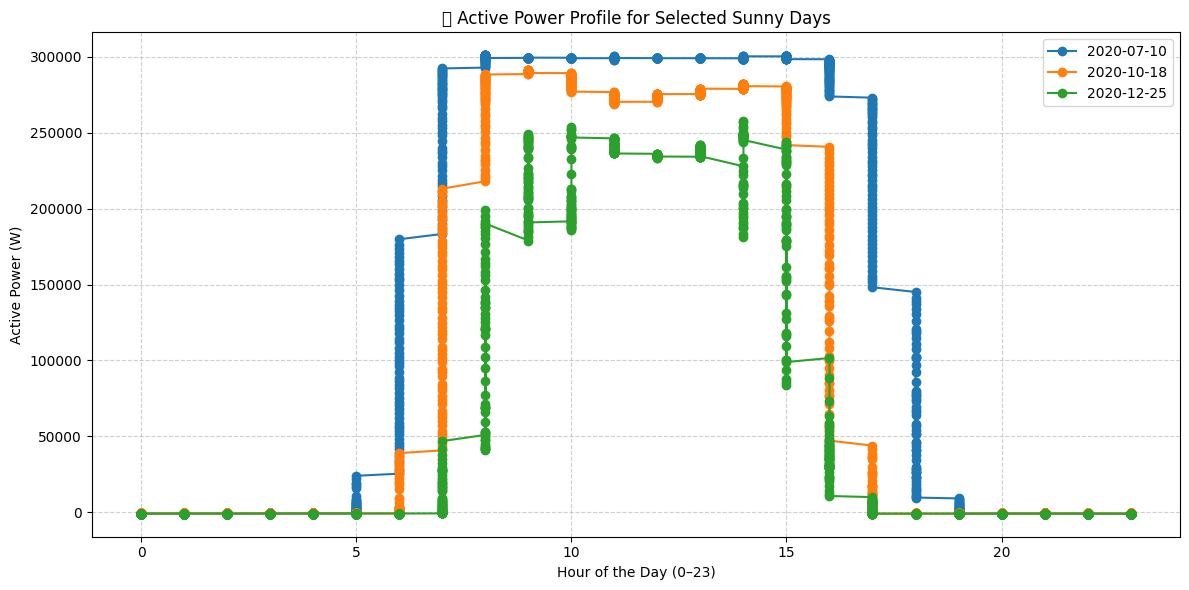

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


df = df1_cleaned_unique_time.copy()
df['time'] = pd.to_datetime(df['time'], errors='coerce')


df['hour'] = df['time'].dt.hour
df['date'] = df['time'].dt.date


sample_dates = ['2020-07-10', '2020-10-18', '2020-12-25']

plt.figure(figsize=(12,6))

for date in sample_dates:
    day_data = df[df['date'] == pd.to_datetime(date).date()]
    if day_data.empty:
        continue
    plt.plot(day_data['hour'], day_data['activepower_1m'],
             marker='o', label=f"{date}")

plt.title("🔆 Active Power Profile for Selected Sunny Days")
plt.xlabel("Hour of the Day (0–23)")
plt.ylabel("Active Power (W)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
df = all_dfs_to_clean[0].copy()

df['time'] = pd.to_datetime(df['time'], errors='coerce')

df = df.dropna(subset=['time'])

df['hour'] = df['time'].dt.hour

hourly_avg = df.groupby('hour')['activepower_1m'].mean()
plt.figure(figsize=(12,5))
hourly_avg.plot(marker='o')
plt.title("Average Active Power per Hour")
plt.xlabel("Hour of the Day (0–23)")
plt.ylabel("Average Active Power (W)")
plt.grid(True)
plt.show()


ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

<Figure size 1200x500 with 0 Axes>

In [18]:
all_dfs_to_clean[0].sample(10)

,time,poa1_w_m2,poa1_wh_m2,poa2_w_m2,poa2_wh_m2,ghi_w_m2,ghi_wh_m2,ambienttemp_c,moduletemp1_c,moduletemp2_c,wind_speed_m_s,wind_dir_deg,rain_mm,humidity_pct,soiling_loss_isc_pct,soiling_loss_geff_pct,isc_test_a,isc_ref_a,temp_test_c,temp_refcell_c,geff_test_w_m2,geff_ref_w_m2,activepower_1m
504708,2020-12-17 19:05:00,0.000000,4566.507812,0.000000,4551.573242,0.000000,3556.416016,13.598000,10.126219,10.142547,0.000,282.989471,0.0,59.063000,0.546695,0.496557,0.000152,-0.000063,10.851929,10.668365,0.050000,-0.020590,-1012.01520
327804,2020-08-16 22:41:00,0.000000,10417.757812,0.000000,10441.170898,0.000000,7410.665527,25.316000,20.710640,20.797926,0.000,164.733734,0.0,21.500000,1.674982,1.746065,0.000116,0.000036,20.995178,20.426819,0.038043,0.011709,-836.37836
368495,2020-09-14 04:52:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.514000,21.393206,21.338375,1.400,140.468216,0.0,25.846001,-0.057604,-0.103760,-0.000071,0.000098,22.219940,21.646179,-0.023397,0.032180,-909.80630
438922,2020-11-02 02:39:00,0.000000,0.000000,0.000000,0.029995,0.000000,0.000000,20.330999,18.570614,18.501873,2.825,13.949709,0.0,34.946999,1.814181,1.807584,0.000054,-0.000089,18.736664,18.743286,0.017578,-0.029297,-907.65920
84171,2020-02-28 14:35:00,913.316284,5945.405762,915.058594,5946.979492,735.320190,4710.262207,25.094000,50.684914,51.320915,0.000,8.646120,0.0,18.218000,0.070182,-0.387429,2.600939,2.608464,54.355377,54.213135,-397.594208,-392.681854,300928.88000
301070,2020-07-29 09:07:00,855.307861,1280.212036,860.160156,1292.679077,597.319824,846.691895,36.271000,53.088413,53.299675,3.125,250.403870,0.0,26.916000,0.419047,0.414231,2.429316,2.457235,53.544922,53.748230,782.563354,791.475220,268711.06000
145398,2020-04-12 05:35:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.094000,5.361153,5.292009,0.000,244.001633,0.0,57.637001,1.341320,-5.855797,0.000483,0.000429,6.130524,5.455841,0.306503,0.277176,-598.43530
251337,2020-06-24 20:13:00,0.000000,11845.845703,0.000000,11825.037109,0.000000,8652.514648,31.100000,27.015411,26.965620,2.075,240.859116,0.0,6.920000,0.599371,0.602960,0.000161,0.000045,28.581970,28.307800,0.052475,0.014579,-1114.47440
9509,2020-01-07 14:30:00,711.257385,4255.761719,707.120483,4255.773438,533.077209,3372.881836,20.170000,31.483946,31.917555,4.175,170.963608,0.0,21.893999,0.000000,0.000000,1.992252,2.008454,30.168579,31.862732,482.809204,431.137207,254730.95000
99042,2020-03-09 22:26:00,0.000000,7871.690918,0.000000,7958.546875,0.000000,5933.973633,14.573000,11.083747,11.021458,1.400,121.958542,0.0,40.824001,0.521983,-4.949492,0.000098,0.000125,12.080078,11.462250,0.052879,0.068564,-620.59790


In [19]:
df['poa1_w_m2'].isna().sum()

np.int64(1003)

In [20]:
try:
    from helpers.fill_missing_values import fill_missing_values_for_all
    print("Function 'fill_missing_values_for_all' imported successfully.")
except ImportError:
    print("ERROR: Could not find the file 'fill_missing_values.py'.")
    print("Please make sure it's in the same directory as your notebook.")


if 'all_dfs_to_clean' not in locals():
    print("WARNING: 'all_dfs_to_clean' is not defined.")
    # all_dfs_to_clean = [df1, df2, ...]
else:
    print(f"Found {len(all_dfs_to_clean)} DataFrames to process.")


try:
    filled_dfs = fill_missing_values_for_all(
        df_list=all_dfs_to_clean, 
        days_window=7
    )
    
    print("\n--- ✅ Function execution finished. ---")

    
    if 'filled_dfs' in locals() and filled_dfs:
        print(f"Successfully processed and stored {len(filled_dfs)} DataFrames in 'filled_dfs'.")
        print(f"Shape of the first filled DataFrame: {filled_dfs[0].shape}")
        
        
        nan_count = filled_dfs[0].isna().sum().sum()
        print(f"Total NaN values in the first file: {nan_count}")
        
        
        display(filled_dfs[0].head())
        
except Exception as e:
    print(f"\n---  An error occurred during execution ---")
    print(e)

Function 'fill_missing_values_for_all' imported successfully.
Found 5 DataFrames to process.
---  Starting Missing Value Fill Process for 5 files ---
--- Window size: ±7 days ---

Processing file 1/5 (Original Shape: (525163, 23))...
  > Processing 23 numeric columns...
  > Warning: Skipped column minute_of_day: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.


c:\Users\njood\Solar_project\helpers\fill_missing_values.py:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill').fillna(method='bfill')


 File 1 done — New shape: (525600, 23)

Processing file 2/5 (Original Shape: (525163, 23))...
  > Processing 23 numeric columns...
  > Warning: Skipped column minute_of_day: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.


c:\Users\njood\Solar_project\helpers\fill_missing_values.py:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill').fillna(method='bfill')


 File 2 done — New shape: (525600, 23)

Processing file 3/5 (Original Shape: (525163, 23))...
  > Processing 23 numeric columns...
  > Warning: Skipped column minute_of_day: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.


c:\Users\njood\Solar_project\helpers\fill_missing_values.py:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill').fillna(method='bfill')


 File 3 done — New shape: (525600, 23)

Processing file 4/5 (Original Shape: (525163, 23))...
  > Processing 23 numeric columns...
  > Warning: Skipped column minute_of_day: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.


c:\Users\njood\Solar_project\helpers\fill_missing_values.py:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill').fillna(method='bfill')


 File 4 done — New shape: (525600, 23)

Processing file 5/5 (Original Shape: (525163, 23))...
  > Processing 23 numeric columns...
  > Warning: Skipped column minute_of_day: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.


c:\Users\njood\Solar_project\helpers\fill_missing_values.py:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged = merged.fillna(method='ffill').fillna(method='bfill')


 File 5 done — New shape: (525600, 23)

---  All files processed. ---

--- ✅ Function execution finished. ---
Successfully processed and stored 5 DataFrames in 'filled_dfs'.
Shape of the first filled DataFrame: (525600, 23)
Total NaN values in the first file: 0


,time,poa1_w_m2,poa1_wh_m2,poa2_w_m2,poa2_wh_m2,ghi_w_m2,ghi_wh_m2,ambienttemp_c,moduletemp1_c,moduletemp2_c,wind_speed_m_s,wind_dir_deg,rain_mm,humidity_pct,soiling_loss_isc_pct,soiling_loss_geff_pct,isc_test_a,isc_ref_a,temp_test_c,temp_refcell_c,geff_test_w_m2,geff_ref_w_m2,activepower_1m
0,2020-01-01 00:00:00,0.0,5034.775739,0.0,5016.966204,0.0,3847.672607,6.437857,3.653037,3.529235,2.257143,171.793029,0.0,59.614143,-13.065547,-12.381068,-0.000006,0.000057,4.572793,4.058929,-0.004182,0.037199,-570.378017
1,2020-01-01 00:01:00,0.0,5469.738281,0.0,5449.306152,0.0,4024.657471,4.826000,0.759169,0.722077,0.000000,259.248779,0.0,69.008003,-15.222034,-17.403786,-0.000080,0.000143,1.642548,1.101715,-0.056982,0.102565,-574.333070
2,2020-01-01 00:02:00,0.0,5469.738281,0.0,5449.306152,0.0,4024.657471,4.754000,0.735785,0.696275,0.000000,259.230774,0.0,69.246002,-15.222034,-17.403786,0.000009,-0.000036,1.602173,1.042450,0.006337,-0.025676,-574.393300
3,2020-01-01 00:03:00,0.0,5469.738281,0.0,5449.306152,0.0,4024.657471,4.714000,0.729334,0.681357,0.000000,259.232086,0.0,69.517998,-15.222034,-17.403786,0.000054,0.000054,1.595886,1.025787,0.038029,0.038528,-574.595950
4,2020-01-01 00:04:00,0.0,5469.738281,0.0,5449.306152,0.0,4024.657471,4.766000,0.742639,0.700306,0.000000,259.234314,0.0,69.666000,-15.222034,-17.403786,0.000152,0.000071,1.669189,1.085815,0.107567,0.051301,-574.301300


**Fill missing values for all columns in all files by replace NaN values with the average of the values of the same min in 7 days before and after it**

In [21]:
filled_dfs[0].isna().sum()

time                     0
poa1_w_m2                0
poa1_wh_m2               0
poa2_w_m2                0
poa2_wh_m2               0
ghi_w_m2                 0
ghi_wh_m2                0
ambienttemp_c            0
moduletemp1_c            0
moduletemp2_c            0
wind_speed_m_s           0
wind_dir_deg             0
rain_mm                  0
humidity_pct             0
soiling_loss_isc_pct     0
soiling_loss_geff_pct    0
isc_test_a               0
isc_ref_a                0
temp_test_c              0
temp_refcell_c           0
geff_test_w_m2           0
geff_ref_w_m2            0
activepower_1m           0
dtype: int64

In [ ]:
# -
import pandas as pd


from helpers.fill_missing_values import fill_missing_values_for_all

filled_dfs = fill_missing_values_for_all(
    df_list=all_dfs_to_clean, 
    days_window=7
)


print("\nProcess finished.")
if filled_dfs:
    print(f"Total DataFrames processed successfully: {len(filled_dfs)}")
    print(f"Shape of first cleaned file: {filled_dfs[0].shape}")

---  Starting Missing Value Fill Process for 5 files ---
--- Window size: ±7 days ---

Processing file 1/5 (Original Shape: (525163, 23))...
  > Processing 23 numeric columns...
  > Warning: Skipped column minute_of_day: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.
 File 1 done — New shape: (525600, 23)

Processing file 2/5 (Original Shape: (525163, 23))...
  > Processing 23 numeric columns...
  > Warning: Skipped column minute_of_day: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.
 File 2 done — New shape: (525600, 23)

Processing file 3/5 (Original Shape: (525163, 23))...
  > Processing 23 numeric columns...
  > Warning: Skipped column minute_of_day: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The 

In [22]:
filled_dfs[0].isna().sum()

time                     0
poa1_w_m2                0
poa1_wh_m2               0
poa2_w_m2                0
poa2_wh_m2               0
ghi_w_m2                 0
ghi_wh_m2                0
ambienttemp_c            0
moduletemp1_c            0
moduletemp2_c            0
wind_speed_m_s           0
wind_dir_deg             0
rain_mm                  0
humidity_pct             0
soiling_loss_isc_pct     0
soiling_loss_geff_pct    0
isc_test_a               0
isc_ref_a                0
temp_test_c              0
temp_refcell_c           0
geff_test_w_m2           0
geff_ref_w_m2            0
activepower_1m           0
dtype: int64

In [23]:
filled_dfs[0].columns

Index(['time', 'poa1_w_m2', 'poa1_wh_m2', 'poa2_w_m2', 'poa2_wh_m2',
       'ghi_w_m2', 'ghi_wh_m2', 'ambienttemp_c', 'moduletemp1_c',
       'moduletemp2_c', 'wind_speed_m_s', 'wind_dir_deg', 'rain_mm',
       'humidity_pct', 'soiling_loss_isc_pct', 'soiling_loss_geff_pct',
       'isc_test_a', 'isc_ref_a', 'temp_test_c', 'temp_refcell_c',
       'geff_test_w_m2', 'geff_ref_w_m2', 'activepower_1m'],
      dtype='object')

**Marged files by mean of all files**

In [25]:
# -
import pandas as pd
from IPython.display import display

from helpers.merge_files import merge_files


master_df = merge_files(
    filled_dfs_list=filled_dfs,
    output_path="master_solar_dataset_filled.parquet"
)


print("\n--- Displaying head of the final master_df ---")
display(master_df.head())


---  Final Step: Merging and Aggregating All Filled Files ---
Merging 5 files horizontally...
Averaging environmental and operational columns...

 --- Aggregation Complete! ---
 Output saved to: master_solar_dataset_filled.parquet
 Shape: (525600, 22)
 Time Range: 2020-01-01 00:00:00 → 2020-12-31 23:59:00
 Columns: ['active_power', 'avg_poa1_w_m2', 'avg_poa1_wh_m2', 'avg_poa2_w_m2', 'avg_poa2_wh_m2', 'avg_ghi_w_m2', 'avg_ghi_wh_m2', 'avg_ambienttemp_c', 'avg_moduletemp1_c', 'avg_moduletemp2_c', 'avg_wind_speed_m_s', 'avg_wind_dir_deg', 'avg_rain_mm', 'avg_humidity_pct', 'avg_soiling_loss_isc_pct', 'avg_soiling_loss_geff_pct', 'avg_isc_test_a', 'avg_isc_ref_a', 'avg_temp_test_c', 'avg_temp_refcell_c', 'avg_geff_test_w_m2', 'avg_geff_ref_w_m2']


,active_power,avg_poa1_w_m2,avg_poa1_wh_m2,avg_poa2_w_m2,avg_poa2_wh_m2,avg_ghi_w_m2,avg_ghi_wh_m2,avg_ambienttemp_c,avg_moduletemp1_c,avg_moduletemp2_c,avg_wind_speed_m_s,avg_wind_dir_deg,avg_rain_mm,avg_humidity_pct,avg_soiling_loss_isc_pct,avg_soiling_loss_geff_pct,avg_isc_test_a,avg_isc_ref_a,avg_temp_test_c,avg_temp_refcell_c,avg_geff_test_w_m2,avg_geff_ref_w_m2
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000
mean,104380.397549,326.273677,3833.901117,324.535774,3818.175718,251.084873,2950.944351,22.629675,27.716300,27.711596,2.424151,192.353166,0.000014,33.791224,0.134044,0.327602,0.924890,0.927334,28.596730,28.260554,243.963876,246.853475
std,128042.151737,404.867177,3691.207632,403.092093,3680.701525,329.662075,2856.164450,10.243937,17.587290,17.554661,1.644865,87.080912,0.000619,23.266978,3.714780,4.373157,1.152399,1.156111,18.161806,17.896926,351.021391,351.956110
min,-3307.371600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.089600,-4.385666,-4.467583,0.000000,0.082483,0.000000,3.668000,-32.613170,-36.167997,-0.000333,-0.000441,-4.270007,-4.421118,-727.019324,-667.800659
25%,-858.361940,0.000000,0.013458,0.000000,0.019664,0.000000,0.000000,14.327400,13.753418,13.762318,1.190000,120.080703,0.000000,15.536400,0.188300,0.348770,0.000027,0.000054,14.127162,14.021394,0.007675,0.017795
50%,910.680200,3.238214,3208.436401,3.767996,3176.572119,2.930885,2453.367676,22.723800,24.234365,24.261902,2.135000,199.456153,0.000000,25.633500,0.605097,0.747286,0.018653,0.018665,24.803577,24.658951,0.320608,0.440755
75%,257612.390000,748.909634,6903.242139,735.230347,6874.701587,527.264737,5482.221045,30.571000,40.501960,40.518370,3.395000,267.647318,0.000000,47.442250,0.960937,1.501379,2.131053,2.130451,41.969722,41.432121,535.272156,540.876955
max,320480.380000,1282.647852,11785.426953,1278.203735,11763.999805,1215.182544,8695.214648,47.071400,71.715672,71.330202,12.080000,350.873810,0.100000,99.968401,2.213494,5.612052,3.692222,3.720214,75.448676,74.365991,1183.087402,1222.846497



--- Displaying head of the final master_df ---


,active_power,avg_poa1_w_m2,avg_poa1_wh_m2,avg_poa2_w_m2,avg_poa2_wh_m2,avg_ghi_w_m2,avg_ghi_wh_m2,avg_ambienttemp_c,avg_moduletemp1_c,avg_moduletemp2_c,avg_wind_speed_m_s,avg_wind_dir_deg,avg_rain_mm,avg_humidity_pct,avg_soiling_loss_isc_pct,avg_soiling_loss_geff_pct,avg_isc_test_a,avg_isc_ref_a,avg_temp_test_c,avg_temp_refcell_c,avg_geff_test_w_m2,avg_geff_ref_w_m2
time,,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,-570.378017,0.0,5017.149742,0.0,4997.433929,0.0,3844.681717,6.365543,3.176098,3.203036,2.085716,162.795849,0.0,61.324286,-19.434906,-21.971026,-0.000029,0.000023,3.942682,3.597567,-0.020545,0.015635
2020-01-01 00:01:00,-574.333070,0.0,5447.921387,0.0,5417.675488,0.0,4030.917676,4.738800,0.620720,0.650394,0.000000,244.821686,0.0,70.472401,-32.444902,-36.167997,-0.000039,0.000104,1.191766,0.849969,-0.028245,0.074461
2020-01-01 00:02:00,-574.393300,0.0,5447.921387,0.0,5417.675488,0.0,4030.917676,4.694000,0.591692,0.620398,0.000000,244.838077,0.0,70.586400,-32.444902,-36.167997,0.000021,0.000036,1.138495,0.816095,0.015426,0.025862
2020-01-01 00:03:00,-574.595950,0.0,5447.921387,0.0,5417.675488,0.0,4030.917676,4.659400,0.570486,0.598143,0.000000,244.802246,0.0,70.773999,-32.444902,-36.167997,-0.000009,0.000052,1.103754,0.779285,-0.006552,0.037500
2020-01-01 00:04:00,-574.301300,0.0,5447.921387,0.0,5417.675488,0.0,4030.917676,4.634000,0.563067,0.593627,0.000000,244.786856,0.0,71.044200,-32.444902,-36.167997,-0.000005,0.000095,1.100879,0.775098,-0.003966,0.068582


In [26]:
master_df.columns

Index(['active_power', 'avg_poa1_w_m2', 'avg_poa1_wh_m2', 'avg_poa2_w_m2',
       'avg_poa2_wh_m2', 'avg_ghi_w_m2', 'avg_ghi_wh_m2', 'avg_ambienttemp_c',
       'avg_moduletemp1_c', 'avg_moduletemp2_c', 'avg_wind_speed_m_s',
       'avg_wind_dir_deg', 'avg_rain_mm', 'avg_humidity_pct',
       'avg_soiling_loss_isc_pct', 'avg_soiling_loss_geff_pct',
       'avg_isc_test_a', 'avg_isc_ref_a', 'avg_temp_test_c',
       'avg_temp_refcell_c', 'avg_geff_test_w_m2', 'avg_geff_ref_w_m2'],
      dtype='object')

--- Starting Combined Feature Ranking ---
Preparing data...
Calculating correlations...
Training LightGBM for feature importance...
Combining metrics and ranking...

 Combined Ranking of Features:


,Pearson,Spearman,Importance,Score
avg_ghi_w_m2,0.954,0.922,0.782,0.886
avg_poa1_w_m2,0.990,0.931,0.719,0.880
avg_poa2_w_m2,0.989,0.930,0.514,0.811
avg_isc_test_a,0.988,0.870,0.503,0.787
avg_isc_ref_a,0.987,0.872,0.228,0.696
avg_geff_test_w_m2,0.816,0.722,0.236,0.591
avg_moduletemp1_c,0.826,0.648,0.286,0.587
avg_temp_test_c,0.828,0.652,0.278,0.586
avg_geff_ref_w_m2,0.825,0.744,0.171,0.580
avg_ambienttemp_c,0.432,0.275,1.000,0.569


Generating plot...


c:\Users\njood\Solar_project\helpers\feature_selection.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


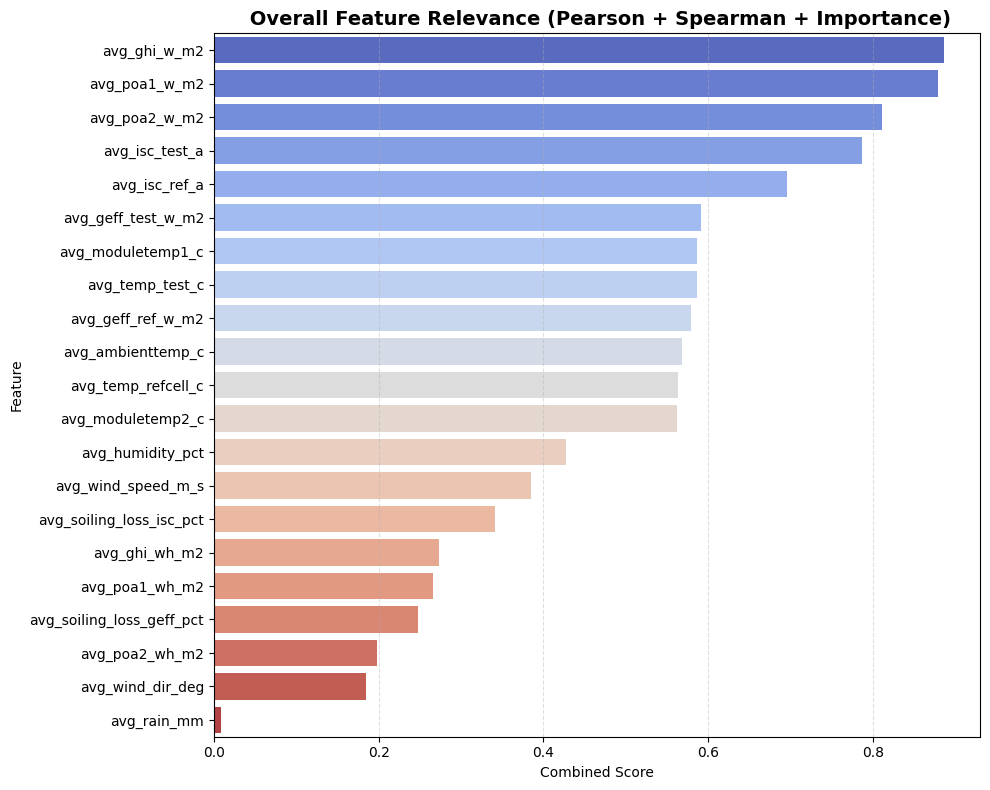

--- Feature Ranking Complete ---

Top 15 feature names: ['avg_ghi_w_m2', 'avg_poa1_w_m2', 'avg_poa2_w_m2', 'avg_isc_test_a', 'avg_isc_ref_a', 'avg_geff_test_w_m2', 'avg_moduletemp1_c', 'avg_temp_test_c', 'avg_geff_ref_w_m2', 'avg_ambienttemp_c', 'avg_temp_refcell_c', 'avg_moduletemp2_c', 'avg_humidity_pct', 'avg_wind_speed_m_s', 'avg_soiling_loss_isc_pct']


In [28]:
#import importlib
import helpers.feature_selection


#importlib.reload(helpers.feature_selection)


from helpers.feature_selection import rank_features_combined


combined_ranking = rank_features_combined(master_df, plot=True)


top_15_features = combined_ranking.index.tolist()[:15]
print(f"\nTop 15 feature names: {top_15_features}")

In [31]:
from helpers.xgb_pred import xgboost_pred


param_grid = {
    "max_depth": [3, 6, 9],
    "learning_rate": [0.05, 0.1, 0.01],
    "n_estimators": [300, 900, 1100],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5]
}


model_g2, metrics_g2, params_g2, features_g2, y_test_actual, y_test_pred = xgboost_pred(
    master_df=master_df,
    param_grid=param_grid,
    subset_fraction=0.2 
)


print("\n---  Preparing Data for Residual Plots ---")
results_df = pd.DataFrame({
    'actual': y_test_actual,
    'predicted': y_test_pred
})
results_df['residual'] = results_df['actual'] - results_df['predicted']
display(results_df.head())


--- Running Prediction for Group: G2_Smart_Choice_NonLinear ---
  Using features (6): ['avg_isc_test_a', 'avg_geff_test_w_m2', 'avg_moduletemp1_c', 'avg_temp_refcell_c', 'avg_wind_speed_m_s', 'avg_humidity_pct']
  Running GridSearchCV on subset...
  Converting data to NumPy arrays for parallel processing...
  Best params (subset): {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 900, 'subsample': 0.8}
  Best CV RMSE (subset): 19,294 W
  Subset Test  metrics:
  MAE   = 9,358 W
  RMSE  = 21,019 W
  R2    = 0.9738
  MedAE = 3,201 W
  EVS   = 0.9752

  Training on FULL data with best params...

  FULL Train metrics:
  MAE   = 4,598 W
  RMSE  = 12,093 W
  R2    = 0.9916
  MedAE = 1,202 W
  EVS   = 0.9916
  FULL Test  metrics:
  MAE   = 4,436 W
  RMSE  = 10,607 W
  R2    = 0.9897
  MedAE = 672 W
  EVS   = 0.9902

---  Preparing Data for Residual Plots ---


,actual,predicted,residual
time,,,
2020-10-20 00:00:00,-867.89685,-1104.232056,236.335206
2020-10-20 00:01:00,-867.46277,-1104.232056,236.769286
2020-10-20 00:02:00,-868.67834,-1104.232056,235.553716
2020-10-20 00:03:00,-868.51794,-1104.232056,235.714116
2020-10-20 00:04:00,-869.75806,-1104.232056,234.473996


--- 1. Residual Density (KDE) Plot ---


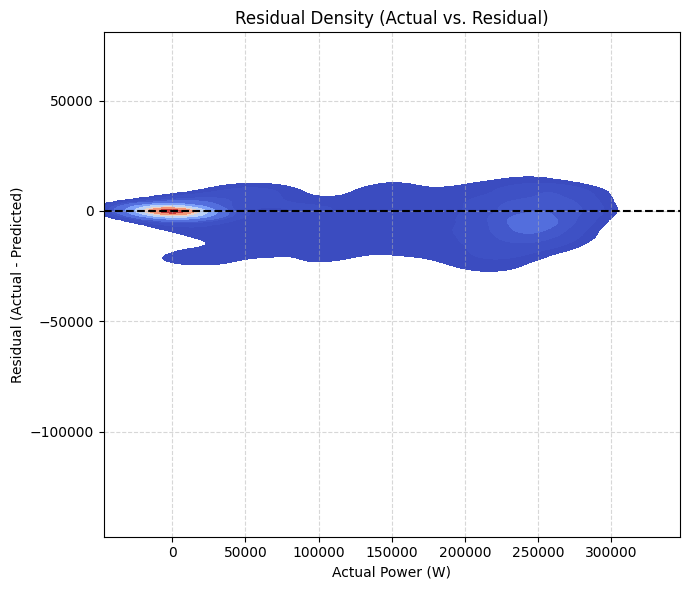

In [ ]:
print("--- 1. Residual Density (KDE) Plot ---")
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=results_df,
    x="actual", 
    y="residual", 
    fill=True, 
    cmap="coolwarm", 
    thresh=0.05
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Residual Density (Actual vs. Residual)")
plt.xlabel("Actual Power (W)")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

--- 2. Residual Scatter Plot ---


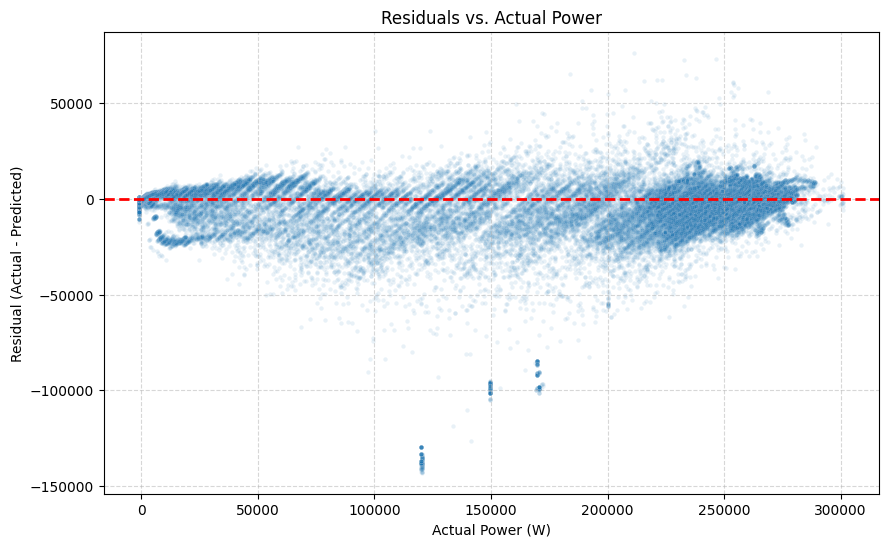

In [33]:
print("--- 2. Residual Scatter Plot ---")
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df,
    x="actual",
    y="residual",
    alpha=0.1,
    s=10        
)
plt.axhline(0, color="red", linestyle="--", lw=2)
plt.title("Residuals vs. Actual Power")
plt.xlabel("Actual Power (W)")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

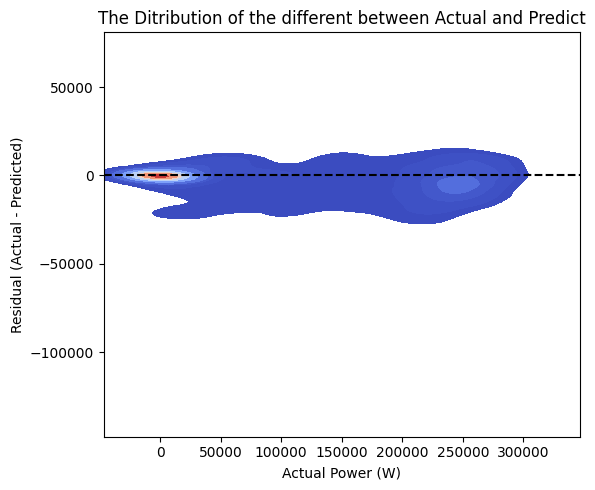

In [34]:
plt.figure(figsize=(6,5))
sns.kdeplot(
    x=results_df["actual"], 
    y=results_df["residual"], 
    fill=True, cmap="coolwarm", thresh=0.05
)
plt.axhline(0, color="black", linestyle="--")
plt.title("The Ditribution of the different between Actual and Predict")
plt.xlabel("Actual Power (W)")
plt.ylabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()


#  Pearson Correlation Coefficient (r)

The **Pearson correlation coefficient**, often denoted by \( r \), measures the **strength and direction of the linear relationship** between two variables.

---

##  Mathematical Definition

Given two variables \( X \) and \( Y \) with \( n \) observations:

$$
r = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2} \sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2}}
$$

Where:
- \( x_i, y_i \) → individual data points  
- \( \bar{x}, \bar{y} \) → means of \( X \) and \( Y \)

---

##  Interpretation

| Range of \( r \) | Meaning |
|------------------|----------|
| \( r = +1 \) | Perfect positive linear correlation |
| \( r = -1 \) | Perfect negative linear correlation |
| \( r = 0 \) | No linear relationship |

---

##  Intuition

- When \( X \) increases and \( Y \) increases too → \( r > 0 \)  
- When \( X \) increases and \( Y \) decreases → \( r < 0 \)  
- When \( X \) and \( Y \) vary randomly → \( r \approx 0 \)

---

##  Example in Python

```python
import pandas as pd

# Example data
df = pd.DataFrame({
    'Hours_Studied': [1, 2, 3, 4, 5],
    'Exam_Score': [50, 55, 65, 70, 80]
})

# Calculate Pearson correlation
r = df['Hours_Studied'].corr(df['Exam_Score'], method='pearson')
print("Pearson r =", round(r, 3))


#  XGBoost (Extreme Gradient Boosting)

**XGBoost** is a high-performance implementation of the **Gradient Boosting** algorithm.  
It combines multiple weak learners (usually decision trees) to form a strong predictive model.

---

## 1. Core Idea

XGBoost minimizes an **objective function** that combines the model’s **training loss** and a **regularization term** to control complexity.

$$
\text{Obj} = \sum_{i=1}^{n} L(y_i, \hat{y}_i) + \sum_{t=1}^{T} \Omega(f_t)
$$

Where:

- \( L(y_i, \hat{y}_i) \): loss function (e.g. mean squared error)  
- \( f_t \): the \(t\)-th decision tree  
- \( \Omega(f_t) = \gamma T + \frac{1}{2}\lambda \sum_j w_j^2 \): regularization term  

Parameters:  
- \( \gamma \): penalty for the number of leaves (controls tree growth)  
- \( \lambda \): L2 regularization term (prevents overfitting)  
- \( w_j \): weight of leaf \( j \)

---

## 2️. Gradient Boosting Process

At each iteration \( t \), XGBoost adds a new tree to reduce the residual errors of the previous prediction.

### Step 1 — Start with a base prediction
$$
\hat{y}_i^{(0)} = \arg \min_c \sum_{i=1}^{n} L(y_i, c)
$$
Usually the mean of \( y \) for regression.

---

### Step 2 — Compute gradients and Hessians
For each data point \( i \):

$$
g_i = \frac{\partial L(y_i, \hat{y}_i^{(t-1)})}{\partial \hat{y}_i^{(t-1)}} \quad , \quad
h_i = \frac{\partial^2 L(y_i, \hat{y}_i^{(t-1)})}{\partial \hat{y}_i^{(t-1)2}}
$$

- \( g_i \): gradient (first derivative)  
- \( h_i \): Hessian (second derivative)

---

### Step 3 — Build a tree to fit the gradients
The algorithm fits a decision tree \( f_t(x) \) that predicts the residuals.

Each leaf \( j \) gets an optimal weight:

$$
w_j^* = -\frac{\sum_{i \in I_j} g_i}{\sum_{i \in I_j} h_i + \lambda}
$$

and the **gain** from splitting a node is:

$$
Gain = \frac{1}{2} \left[\frac{(\sum_{i \in I_L} g_i)^2}{\sum_{i \in I_L} h_i + \lambda} +
\frac{(\sum_{i \in I_R} g_i)^2}{\sum_{i \in I_R} h_i + \lambda} -
\frac{(\sum_{i \in I} g_i)^2}{\sum_{i \in I} h_i + \lambda}\right] - \gamma
$$

---

### Step 4 — Update the model
$$
\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \eta \cdot f_t(x_i)
$$

Where \( \eta \) is the **learning rate** that controls how much each new tree contributes.

---

## 3️. Why XGBoost is Powerful

Uses **second-order derivatives (Hessian)** for precise optimization  
Includes **regularization** → prevents overfitting  
Performs **tree pruning** for optimal structure  
Handles **missing values** automatically  
Supports **parallel & distributed computation**


In [35]:

print(f" Model ready : {type(model_g2)}")
print(f" Features : {features_g2}")

 Model ready : <class 'xgboost.sklearn.XGBRegressor'>
 Features : ['avg_isc_test_a', 'avg_geff_test_w_m2', 'avg_moduletemp1_c', 'avg_temp_refcell_c', 'avg_wind_speed_m_s', 'avg_humidity_pct']


In [36]:
import joblib
import json

# Store the model
joblib.dump(model_g2, 'model.joblib')

# Save the list of features
with open('features.json', 'w') as f:
    json.dump(features_g2, f)

print("The Model Stored joblib")

The Model Stored joblib


# Conclusion

At the conclusion of this project, I would like to express my sincere gratitude to my supervisor, [**Eng. Mohammed Mohana**](https://www.linkedin.com/in/mohdmohana/)
, for granting me the opportunity to embark on this enriching and insightful experience.
His constant guidance, patience, and valuable feedback have been instrumental in expanding my knowledge and helping me explore deeper and more innovative aspects of the topic.
Despite his busy schedule, he always responded with kindness and dedication, sharing his time and expertise generously.
I am deeply thankful for his mentorship and continuous encouragement, which have greatly contributed to the success of this work.